In [1]:
# first we import all relevant packages
from bulk import * # bulk.py stores a lot of my personal functions, i.e. for reading from the .data files and such
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pynbody
from scipy import stats
from scipy.stats import binned_statistic

pynbody.config['halo-class-priority'] =  [pynbody.halo.ahf.AHFCatalogue,
                                          pynbody.halo.GrpCatalogue,
                                          pynbody.halo.AmigaGrpCatalogue,
                                          pynbody.halo.legacy.RockstarIntermediateCatalogue,
                                          pynbody.halo.rockstar.RockstarCatalogue,
                                          pynbody.halo.subfind.SubfindCatalogue, pynbody.halo.hop.HOPCatalogue]

In [2]:
# we set the global matplotlib parameters so the fonts are all consistent and serif 
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})
mpl.rcParams['hatch.linewidth'] = 0.8

In [3]:
def read_timescales():
    '''Function to read in the resulting data file which contains quenching and infall times'''
    data = []
    with open('/home/akinshol/Data/Timescales/QuenchingTimescales_sSFR_F19.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

In [4]:
def read_new_data():
    '''Function to read in the resulting data file which contains quenching and infall times'''
    data = []
    with open('/home/akinshol/Data/Timescales/QuenchingTimescales_sSFR_F19.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

In [6]:
snapnums = ['004096', '004032', '003936', '003840', '003744', '003648', '003606', '003552', '003456', '003360', '003264', '003195', '003168', '003072','002976', '002880', '002784', '002688', '002592', '002554', '002496', '002400', '002304','002208', '002112', '002088', '002016', '001920', '001824','001740','001728','001632', '001536', '001475', '001440', '001344', '001269', '001248','001152', '001106', '001056', '000974', '000960','000864', '000776', '000768', '000672', '000637', '000576', '000480', '000456', '000384', '000347', '000288', '000275', '000225', '000192', '000188', '000139', '000107', '000096', '000071']

haloids = {
    1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 5, 19, 16],
    11: [11, 8, 7, 7, 7, 7, 7, 6, 5, 6, 6, 5, 5, 6, 6, 7, 6, 6, 6, 6, 8, 8, 8, 7, 7, 7, 7, 7, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 14, 13, 15, 16, 18, 20, 21, 20, 21, 24, 20, 21, 32],
    31: [31, 31, 31, 32, 32, 29, 28, 19, 15, 14, 15, 14, 14, 15, 14, 14, 14, 14, 14, 14, 13, 13, 13, 12, 11, 11, 11, 11, 11, 11, 11, 10, 10, 9, 10, 10, 19, 23, 24, 26, 27, 38, 39, 38, 41, 41, 48, 43, 46, 46, 49, 61, 62, 70, 73, 92, 84, 81, 106],
    33: [33, 33, 34, 34, 33, 33, 33, 35, 35, 34, 34, 32, 32, 32, 31, 31, 27, 27, 28, 32, 17, 16, 16, 16, 15, 14, 13, 15, 14, 14, 13, 12, 12, 12, 12, 15, 14, 16, 15, 14, 14, 15, 15, 14, 17, 17, 22, 69, 52, 50, 52, 65, 95, 179, 196, 189, 212, 205],
    40: [40, 39, 30, 28, 27, 27, 26, 27, 26, 27, 28, 27, 27, 29, 28, 29, 28, 28, 26, 27, 28, 27, 27, 28, 28, 28, 29, 29, 28, 27, 28, 27, 27, 28, 29, 29, 28, 29, 30, 28, 28, 23, 24, 24, 26, 28, 43, 41, 45, 41, 40, 54, 86, 91, 90, 74, 61, 60, 91],
    64: [64, 63, 63, 62, 61, 65, 64, 64, 60, 58, 59, 56, 57, 56, 52, 50, 47, 44, 45, 44, 43, 44, 41, 41, 40, 40, 40, 38, 39, 41, 41, 43, 43, 43, 42, 39, 44, 46, 45, 43, 44, 41, 41, 40, 53, 52, 54, 59, 70, 151, 151, 157, 159, 170, 176, 143, 99, 95, 77, 60],
    103: [103, 102, 103, 104, 107, 108, 109, 110, 108, 108, 107, 105, 106, 107, 109, 114, 124, 125, 111, 105, 98, 96, 99, 113, 96, 93, 81, 76, 76, 73, 75, 74, 72, 68, 68, 63, 61, 60, 48, 45, 41, 29, 28, 32, 33, 34, 41, 38, 39, 48, 50, 51, 49, 49, 50, 48, 67, 69, 64],
    133: [133, 132, 132, 128, 131, 129, 131, 130, 125, 125, 123, 117, 118, 118, 114, 100, 95, 95, 93, 92, 92, 87, 89, 84, 83, 84, 83, 78, 69, 64, 67, 66, 54, 38, 37, 32, 33, 33, 33, 31, 30, 27, 27, 25, 27, 26, 32, 33, 33, 33, 38, 47, 65, 130, 136, 219],
    137: [137, 138, 136, 137, 140, 136, 137, 138, 139, 139, 139, 137, 140, 143, 140, 133, 122, 122, 117, 113, 66, 55, 56, 53, 54, 54, 52, 52, 52, 46, 45, 44, 37, 31, 24, 14, 13, 15, 14, 13, 13, 16, 16, 15, 16, 16, 20, 21, 23, 23, 20, 23, 23, 22, 19, 19, 15, 15, 11, 20, 23],
    146: [146, 148, 148, 147, 148, 148, 148, 148, 150, 152, 151, 150, 154, 154, 155, 158, 157, 159, 157, 154, 154, 152, 152, 151, 154, 157, 158, 160, 155, 155, 156, 161, 162, 158, 155, 156, 160, 162, 165, 162, 156, 163, 164, 159, 156, 159, 161, 165, 163, 155, 153, 143, 145, 141, 141, 117, 111, 108, 62, 40, 28, 8],
    185: [185, 185, 183, 179, 181, 181, 178, 175, 174, 172, 169, 165, 166, 167, 166, 163, 159, 155, 146, 141, 137, 125, 119, 104, 97, 99, 94, 86, 83, 82, 80, 78, 73, 66, 66, 60, 59, 59, 55, 56, 53, 48, 47, 49, 59, 60, 58, 58, 60, 66, 65, 64, 61, 71, 69, 66, 64, 64, 44, 44, 43],
    447: [447, 438, 429, 409, 381, 359, 549, 434, 230, 191, 213]
}

rvirs = {
    11: [62.0, 61.08, 59.71, 58.36, 57.02, 55.69, 55.21, 54.6, 53.45, 52.19, 51.03, 50.04, 49.57, 48.05, 46.67, 45.2, 43.78, 42.09, 39.97, 38.72, 36.19, 34.38, 33.03, 31.71, 30.55, 30.28, 29.41, 28.28, 27.19, 26.24, 26.09, 24.85, 23.62, 22.76, 22.32, 21.02, 20.06, 19.79, 18.54, 17.98, 17.37, 16.39, 16.19, 14.79, 13.54, 13.44, 12.07, 11.61, 10.88, 9.12, 8.61, 6.85, 5.95, 4.76, 4.42, 3.49, 2.91, 2.83, 1.69],
    31: [49.46, 48.73, 47.63, 46.55, 45.48, 44.43, 43.97, 43.38, 42.34, 41.32, 40.3, 39.57, 39.29, 38.28, 37.22, 36.14, 35.08, 33.98, 32.9, 32.48, 31.83, 30.64, 29.47, 28.46, 27.48, 27.24, 26.44, 25.33, 24.24, 23.31, 23.05, 22.27, 21.41, 20.66, 20.11, 19.08, 16.15, 15.68, 14.13, 13.57, 12.7, 10.25, 10.07, 9.03, 8.2, 8.11, 7.21, 6.89, 6.38, 5.64, 5.37, 4.18, 3.72, 3.03, 2.86, 2.07, 1.85, 1.82, 1.1],
    33: [35.93, 35.37, 34.55, 33.73, 32.95, 32.18, 31.86, 31.46, 30.8, 30.19, 29.66, 29.37, 29.24, 28.91, 34.66, 33.74, 32.83, 31.92, 31.01, 30.65, 30.11, 29.21, 28.31, 27.22, 26.21, 26.0, 25.23, 23.66, 22.75, 21.97, 21.84, 20.88, 19.88, 19.24, 18.83, 17.74, 16.92, 16.67, 15.61, 15.11, 14.58, 13.77, 13.62, 12.51, 11.16, 11.03, 9.91, 3.7, 5.3, 5.31, 5.15, 4.1, 3.14, 2.07, 1.95, 1.58, 1.3, 1.27],
    40: [40.02, 39.42, 38.54, 37.66, 36.8, 35.94, 35.57, 35.1, 34.26, 33.43, 32.56, 31.96, 31.73, 30.81, 29.9, 29.01, 28.1, 27.24, 26.34, 25.96, 25.42, 24.52, 23.56, 22.65, 21.77, 21.56, 20.91, 20.09, 19.35, 18.65, 18.54, 17.71, 16.79, 16.21, 15.88, 14.98, 14.24, 14.03, 13.1, 12.67, 12.26, 11.72, 11.64, 10.7, 9.45, 9.29, 7.35, 6.95, 6.35, 5.79, 5.53, 4.38, 3.28, 2.71, 2.59, 2.23, 2.09, 2.05, 1.15],
    64: [32.14, 31.66, 30.95, 30.25, 29.55, 28.87, 28.57, 28.19, 27.51, 26.85, 26.18, 25.71, 25.53, 24.88, 24.23, 23.59, 22.95, 22.31, 21.68, 21.43, 21.04, 20.4, 19.76, 19.13, 18.5, 18.36, 17.9, 17.28, 16.64, 16.06, 15.98, 15.31, 14.57, 14.11, 13.88, 13.05, 12.27, 12.07, 11.06, 10.73, 10.39, 9.76, 9.68, 8.77, 7.63, 7.58, 6.84, 6.32, 5.51, 3.56, 3.39, 2.82, 2.58, 2.11, 2.01, 1.76, 1.72, 1.69, 1.21, 0.9],
    103: [22.56, 22.3, 21.7, 21.22, 20.76, 20.28, 20.07, 19.81, 19.39, 18.96, 18.57, 18.29, 18.18, 17.81, 15.45, 12.92, 12.57, 12.22, 11.87, 11.74, 11.53, 11.18, 8.38, 4.1, 6.84, 8.19, 12.02, 13.63, 13.15, 12.72, 12.66, 12.13, 11.66, 11.38, 11.25, 10.98, 10.92, 10.93, 10.86, 10.66, 10.83, 11.07, 11.0, 9.9, 8.88, 8.79, 7.55, 7.2, 6.57, 5.53, 5.27, 4.47, 4.14, 3.55, 3.43, 2.8, 2.02, 1.94, 1.29],
    133: [24.29, 23.93, 23.39, 22.86, 22.33, 21.82, 21.59, 21.3, 20.79, 20.29, 19.79, 19.43, 19.29, 18.8, 18.31, 17.82, 17.34, 16.86, 16.38, 16.19, 15.9, 15.47, 15.03, 14.6, 14.18, 14.07, 13.81, 13.53, 17.11, 16.54, 16.45, 15.79, 15.12, 14.7, 14.45, 13.77, 13.35, 13.21, 12.59, 12.32, 11.93, 11.22, 11.1, 10.25, 9.27, 9.25, 8.6, 8.07, 7.33, 6.06, 5.62, 4.61, 3.65, 2.36, 2.2, 1.52],
    137: [19.65, 19.36, 18.93, 18.5, 18.07, 17.65, 17.47, 17.24, 16.83, 16.42, 16.1, 15.77, 15.67, 15.35, 21.84, 21.26, 20.68, 20.11, 19.54, 19.31, 18.97, 18.4, 17.83, 17.27, 16.7, 16.56, 16.15, 15.66, 15.28, 15.15, 21.45, 20.59, 19.72, 19.16, 18.84, 17.95, 17.31, 17.12, 16.04, 15.47, 14.84, 13.75, 13.6, 12.6, 11.65, 11.56, 10.27, 9.85, 9.1, 7.82, 7.43, 6.26, 5.76, 4.78, 4.58, 3.81, 3.37, 3.31, 2.32, 1.28, 1.0],
    146: [19.65, 19.36, 18.93, 18.5, 18.13, 17.75, 17.52, 17.28, 16.83, 16.47, 16.01, 15.8, 15.62, 15.24, 14.88, 14.39, 14.03, 13.58, 13.19, 13.04, 12.8, 12.37, 12.03, 11.58, 11.2, 11.09, 10.81, 10.4, 9.99, 9.65, 9.6, 9.18, 8.75, 8.49, 8.34, 7.9, 7.55, 7.45, 6.99, 6.78, 6.56, 6.17, 6.1, 5.66, 5.22, 5.17, 4.65, 4.44, 4.05, 3.5, 3.37, 2.92, 2.65, 2.27, 2.2, 1.9, 1.65, 1.63, 1.31, 1.03, 0.95],
    185: [25.07, 24.7, 24.14, 23.6, 23.05, 22.52, 22.29, 21.99, 21.46, 20.94, 20.43, 20.06, 19.91, 19.4, 18.9, 18.4, 17.9, 17.4, 16.91, 16.71, 16.42, 15.92, 15.43, 14.94, 14.45, 14.33, 13.96, 13.47, 12.97, 12.54, 12.47, 11.97, 11.66, 12.42, 12.21, 11.64, 11.18, 11.05, 10.46, 10.17, 9.81, 9.29, 9.18, 8.32, 7.35, 7.27, 6.57, 6.32, 5.83, 4.78, 4.54, 4.13, 3.75, 3.02, 2.93, 2.42, 2.05, 2.02, 1.51, 0.99, 0.86],
    447: [25.07, 24.7, 24.14, 23.6, 23.05, 22.52, 22.29, 21.99, 21.46, 20.94, 20.43]
}

In [44]:
print(len(snapnums))

62


In [78]:
i1, i2 = 55,51 # snapshots to step between
f_base = '/home/christenc/Data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h329.cosmo50PLK.3072gst5HbwK1BH.'
f1 = f_base + snapnums[i1]
f2 = f_base + snapnums[i2]
s1 = pynbody.load(f1)
s2 = pynbody.load(f2)

In [79]:
h1 = s1.halos()
h2 = s2.halos()

In [93]:
b = pynbody.bridge.OrderBridge(s1,s2, order_array='iord', allow_family_change=True)

In [50]:
z0haloid = 11
print(f'Halo {z0haloid} in snapshot {snapnums[i1]} is actually halo {haloids[z0haloid][i1]} with rvir {rvirs[z0haloid][i1]}.')
print(f'Halo {z0haloid} in snapshot {snapnums[i2]} is actually halo {haloids[z0haloid][i2]} with rvir {rvirs[z0haloid][i2]}.')

Halo 11 in snapshot 000225 is actually halo 24 with rvir 3.49.
Halo 11 in snapshot 000275 is actually halo 21 with rvir 4.42.


In [51]:
s1.physical_units()
s2.physical_units()

In [94]:
filtered_gas_particles_s1 = h1[1].g
filtered_gas_particles_s2 = b(filtered_gas_particles_s1)

In [26]:
gas_cool_filt = pynbody.filt.LowPass('temp', 1e4) # select all gas particles with T < 1e4 K
gas_highdens_filt = pynbody.filt.HighPass('rho',2453000) # select all gas particles with rho > 0.1 amu/cc (converted into Msol/kpc**3)
gas_filt = gas_cool_filt & gas_highdens_filt 

In [27]:
print(f'In snapshot {snapnums[i1]}, roughly {len(h1[haloids[z0haloid][i1]].g[gas_filt])/len(h1[haloids[z0haloid][i1]])*100:.2f}% of the satellite gas is hot and diffuse')
print(f'In snapshot {snapnums[i2]}, roughly {len(h2[haloids[z0haloid][i2]].g[gas_filt])/len(h2[haloids[z0haloid][i2]])*100:.2f}% of the satellite gas is hot and diffuse')

In snapshot 000974, roughly 2.60% of the satellite gas is hot and diffuse
In snapshot 001056, roughly 1.64% of the satellite gas is hot and diffuse


Centering halo
Making plot


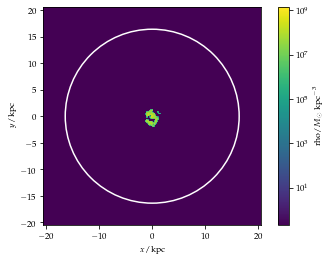

In [28]:
print('Centering halo')
pynbody.analysis.angmom.faceon(h1[haloids[z0haloid][i1]])
print('Making plot')
img_width = str(round(rvirs[z0haloid][i1]*2.5,2)) + ' kpc'

pynbody.plot.sph.image(h1[haloids[z0haloid][i1]].g[gas_filt], width=img_width)
circle = plt.Circle((0,0),rvirs[z0haloid][i1],color = 'w', linestyle='-', fill=False, linewidth=1.5)
plt.gca().add_artist(circle)
plt.show()

In [61]:
np.sum(filtered_gas_particles_s1.g['mass']) - np.sum(filtered_gas_particles_s2.g['mass'])

SimArray(69188087.14336228, 'Msol')

In [25]:
print(len(h1[haloids[z0haloid][i1]].g))
print(len(h2[haloids[z0haloid][i2]].g))

21074
17937


Centering halo
Making plot


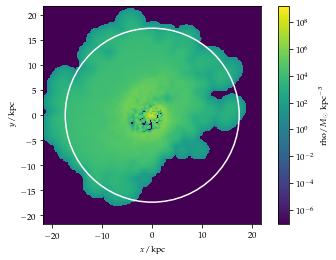

In [76]:
print('Centering halo')
pynbody.analysis.angmom.faceon(h2[haloids[z0haloid][i2]])
print('Making plot')
img_width = str(round(rvirs[z0haloid][i2]*2.5,2)) + ' kpc'

pynbody.plot.sph.image(filtered_gas_particles_s2.g, width=img_width)
circle = plt.Circle((0,0),rvirs[z0haloid][i2],color = 'w', linestyle='-', fill=False, linewidth=1.5)
plt.gca().add_artist(circle)
plt.show()

# Following an Individual Halo at Infall: h242, halo 80

In [104]:
snapnums = ['004096', '004032', '003936', '003840', '003744', '003648', '003606', '003552', '003456', '003360', '003264', '003195', '003168', '003072','002976', '002880', '002784', '002688', '002592', '002554', '002496', '002400', '002304','002208', '002112', '002088', '002016', '001920', '001824','001740','001728','001632', '001536', '001475', '001440', '001344', '001269', '001248','001152', '001106', '001056', '000974', '000960','000864', '000776', '000768', '000672', '000637', '000576', '000480', '000456', '000384', '000347', '000288', '000275', '000225', '000192', '000188', '000139', '000107', '000096', '000071']

haloids = {
    1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 4, 4, 4, 2],
    10: [10, 10, 9, 7, 7, 8, 7, 7, 7, 4, 5, 5, 5, 6, 6, 4, 3, 3, 3, 3, 3, 4, 5, 5, 6, 6, 4, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 6, 9, 9, 9, 10, 10, 9, 13, 14, 16, 18, 18, 18, 20],
    12: [12, 12, 12, 9, 10, 11, 10, 10, 10, 9, 10, 6, 6, 5, 4, 3, 4, 4, 4, 4, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 4, 4, 4, 4, 4, 5, 6, 6, 7, 8, 8, 8, 8, 10, 11, 10, 7, 6, 11, 11, 7, 11, 11, 9, 5, 6, 9],
    24: [24, 24, 25, 26, 25, 25, 25, 24, 24, 23, 24, 25, 24, 22, 22, 22, 21, 20, 19, 19, 19, 19, 19, 20, 19, 19, 17, 20, 21, 21, 20, 21, 17, 16, 17, 15, 15, 16, 15, 18, 17, 17, 17, 20, 21, 21, 20, 21, 24, 26, 28, 25, 24, 27, 29, 23, 20, 19, 14, 12, 16, 17],
    30: [30, 29, 29, 31, 29, 28, 29, 29, 30, 32, 30, 29, 28, 26, 25, 24, 22, 22, 20, 20, 20, 21, 21, 22, 21, 21, 18, 19, 18, 17, 16, 17, 15, 13, 14, 12, 13, 14, 13, 13, 13, 14, 14, 13, 15, 15, 14, 15, 16, 16, 17, 18, 16, 14, 12, 8, 9, 9, 8, 6, 5, 4],
    34: [34, 33, 34, 36, 35, 35, 34, 34, 35, 36, 33, 33, 33, 33, 33, 33, 33, 32, 32, 32, 32, 31, 31, 30, 30, 31, 28],
    40: [40, 40, 41, 44, 41, 41, 42, 41, 42, 42, 40, 39, 40, 39, 38, 38, 38, 38, 38, 38, 39, 38, 37, 38, 38, 38, 37, 36, 37, 35, 34, 34, 34, 32, 33, 34, 32, 34, 35, 38, 40, 38, 38, 42, 38, 38, 39, 40, 45, 50, 49, 49, 52, 57, 55, 50, 40, 41, 31, 25, 26],
    41: [41, 41, 42, 43, 44, 29, 26, 23, 20, 19, 19, 19, 19, 18, 18, 18, 19, 18, 18, 18, 18, 20, 20, 21, 22, 22, 21, 23, 28, 28, 28, 27, 29, 27, 28, 29, 27, 29, 32, 34, 35, 29, 29, 28, 26, 26, 34, 43, 121, 121, 115, 101, 103, 87, 82, 77, 122, 156, 122],
    44: [44, 44, 45, 48, 46, 45, 47, 46, 48, 50, 48, 50, 53, 51, 51, 52, 50, 52, 52, 53, 51, 51, 49, 50, 49, 50, 49, 50, 51, 48, 48, 45, 43, 39, 41, 41, 37, 39, 41, 46, 46, 46, 44, 46, 39, 39, 41, 41, 47, 53, 50, 46, 47, 50, 52, 53, 41, 40, 34, 30, 28, 25],
    48: [48, 50, 48, 51, 51, 50, 52, 51, 54, 54, 52, 53, 57, 55, 53, 53, 53, 54, 54, 54, 54, 53, 51, 49, 48, 48, 47, 51, 55, 54, 53, 57, 57, 57, 59, 60, 58, 61, 68, 68, 67, 67, 66, 69, 66, 66, 56, 57, 66, 67, 65, 59, 64, 71, 75, 85, 95, 94, 86, 77],
    49: [49, 49, 47, 50, 50, 49, 50, 50, 53, 55, 53, 55, 69, 56, 55, 55, 56, 55, 55, 57, 56, 58, 54, 57, 57, 57, 57, 60, 64, 65, 65, 69, 72, 73, 75, 79, 78, 83, 86, 86, 85, 81, 81, 83, 79, 79, 85, 94, 97, 100, 100, 103, 95, 92, 87, 91, 83, 84, 150],
    71: [71, 70, 72, 75, 75, 75, 75, 73, 72, 75, 71, 72, 72, 68, 66, 66, 67, 66, 66, 58, 57, 55, 53, 53, 50, 49, 48, 49, 53, 52, 51, 48, 48, 47, 50, 48, 42, 44, 46, 49, 48, 51, 53, 56, 50, 50, 48, 48, 56, 64, 62, 63, 65, 63, 58, 58, 55, 56, 47, 65],
    78: [78, 76, 76, 78, 76, 71, 70, 68, 64, 65, 63, 66, 65, 64, 62, 61, 62, 62, 60, 61, 59, 59, 60, 59, 59, 58, 56, 57, 60, 63, 62, 64, 62, 61, 62, 62, 60, 62, 67, 69, 68, 63, 63, 60, 45, 44, 47, 47, 54, 57, 51, 52, 62, 82, 77],
    80: [80, 268, 64, 39, 33, 31, 31, 30, 29, 29, 27, 26, 25, 25, 24, 19, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 14, 15, 14, 14, 13, 12, 12, 11, 11, 12, 13, 12, 14, 15, 15, 15, 15, 17, 17, 16, 17, 18, 21, 22, 29, 55, 53, 50, 47, 48, 48, 100],
    86: [86, 82, 83, 84, 82, 79, 80, 80, 76, 67, 51, 48, 47, 46, 47, 46, 46, 47, 45, 46, 45, 43, 42, 40, 39, 39, 38, 37, 39, 36, 35, 35, 35, 33, 34, 38, 35, 37, 36, 39, 42, 37, 35, 40, 41, 41, 51, 54, 58, 58, 56, 55, 57, 74, 73, 76, 88, 87, 112],
    165: [165, 153, 146, 140, 132, 125, 126, 129, 128, 134, 132, 131, 134, 128, 129, 127, 128, 127, 132, 132, 135, 136, 132, 125, 122, 116, 111, 113, 194, 133, 121, 87, 87, 92, 94, 97, 99, 102, 111, 108, 107, 102, 101, 102, 98, 101, 101, 105, 103, 95, 91, 90, 90, 91, 86, 68, 65, 64, 62],
    223: [223, 214, 228, 69, 52, 48, 48, 47, 49, 52, 50, 51, 54, 52, 52, 51, 51, 53, 53, 52, 50, 50, 48, 48, 51, 51, 50, 52, 54, 53, 52, 49, 50, 49, 52, 52, 47, 50, 49, 50, 50, 49, 49, 51, 44, 45, 49, 50, 55, 56, 54, 95, 134, 140, 135, 134, 157, 184, 146],
    439: [439, 441, 439, 442, 439, 432, 431, 430, 416, 401, 379, 367, 366, 341, 318, 283, 223, 176, 174, 170, 174, 173, 176, 178, 174, 173, 174, 176, 176, 176, 175, 168, 158, 141, 136, 122, 89, 78, 65, 63, 60, 53, 52, 43, 31, 31, 22, 22, 23, 27, 27, 26, 26, 30, 30, 31, 34, 36, 74],
    480: [480, 481, 466, 463, 462, 461, 459, 456, 460, 470, 467, 469, 472, 468, 472, 471, 460, 450, 437, 432, 425, 419, 415, 408, 409, 405, 408, 405, 405, 413, 411, 410, 404, 399, 393, 393, 368, 368, 356, 351, 342, 321, 320, 294, 224, 215, 118, 104, 89, 62, 57, 51, 54, 55, 54, 52, 49, 47, 37, 38, 42]
}

rvirs = {
    10: [105.92, 104.34, 102.0, 99.69, 97.4, 95.14, 94.15, 92.89, 90.67, 88.47, 86.29, 84.74, 84.13, 81.98, 79.85, 77.73, 75.62, 73.53, 71.44, 70.61, 69.36, 67.28, 65.21, 63.13, 61.06, 60.54, 58.98, 56.9, 54.81, 52.97, 52.7, 50.58, 48.45, 47.08, 46.3, 44.06, 42.13, 41.56, 38.83, 37.4, 35.91, 33.52, 33.11, 30.53, 28.43, 28.19, 24.91, 23.19, 18.23, 14.15, 13.46, 11.47, 10.1, 7.62, 7.25, 5.41, 4.35, 4.19, 2.65, 1.89, 1.58, 0.81],
    12: [88.48, 87.16, 85.21, 83.27, 81.36, 79.47, 78.65, 77.6, 75.74, 73.9, 72.08, 70.78, 70.28, 68.48, 66.7, 64.93, 63.17, 61.42, 59.67, 59.05, 58.15, 56.77, 55.59, 62.19, 60.15, 59.64, 58.1, 56.05, 53.99, 52.18, 51.92, 49.83, 39.06, 33.66, 34.57, 45.55, 43.99, 43.13, 39.62, 37.89, 34.53, 27.88, 27.33, 24.31, 22.18, 21.98, 19.33, 18.4, 16.21, 13.71, 13.23, 11.97, 10.82, 7.5, 7.12, 5.56, 4.48, 4.35, 3.2, 2.49, 2.13, 1.21],
    24: [49.2, 48.46, 47.38, 46.3, 45.24, 44.19, 43.73, 43.15, 42.12, 41.09, 40.08, 39.36, 39.08, 38.08, 37.09, 36.1, 35.13, 34.15, 33.18, 32.8, 32.21, 31.25, 30.29, 29.32, 31.43, 31.8, 31.02, 29.89, 28.68, 27.66, 27.51, 26.4, 25.37, 24.78, 24.41, 23.28, 22.28, 21.98, 20.39, 19.15, 18.25, 16.54, 16.31, 14.66, 13.4, 13.28, 11.77, 11.19, 10.19, 8.71, 8.33, 7.1, 6.53, 5.51, 5.26, 4.38, 3.82, 3.74, 2.88, 2.05, 1.73, 0.97],
    30: [61.77, 60.85, 59.48, 58.14, 56.8, 55.48, 54.91, 54.17, 52.88, 51.6, 50.32, 49.42, 49.06, 47.81, 46.57, 45.33, 44.1, 42.88, 41.66, 41.18, 40.45, 39.24, 38.03, 36.82, 35.61, 35.31, 34.4, 33.18, 31.96, 30.89, 30.73, 29.5, 28.25, 27.45, 26.99, 25.93, 24.91, 24.62, 23.21, 22.59, 21.74, 20.29, 20.07, 18.42, 17.02, 16.9, 15.66, 15.13, 13.66, 11.27, 10.86, 9.41, 8.44, 7.11, 6.78, 5.54, 4.71, 4.59, 3.26, 2.42, 2.21, 1.54],
    34: [44.33, 43.67, 42.69, 41.73, 40.79, 39.81, 39.4, 38.86, 37.92, 36.95, 36.03, 35.34, 35.09, 34.17, 33.23, 32.33, 31.44, 30.56, 29.65, 29.31, 28.77, 27.92, 27.05, 26.23, 25.45, 25.26, 24.75],
    40: [41.29, 40.67, 39.76, 38.86, 37.97, 37.08, 36.7, 36.21, 35.34, 34.48, 33.64, 33.03, 32.79, 31.96, 31.14, 30.31, 29.49, 28.63, 27.8, 27.46, 26.94, 26.06, 25.17, 24.34, 23.46, 23.24, 22.6, 21.71, 20.81, 19.98, 19.85, 18.94, 18.05, 17.5, 17.19, 16.3, 15.55, 15.32, 14.25, 13.79, 13.33, 12.48, 12.32, 11.15, 10.17, 10.08, 9.0, 8.58, 7.91, 6.74, 6.38, 5.26, 4.8, 3.97, 3.8, 3.26, 2.85, 2.8, 2.24, 1.48, 1.23],
    41: [55.33, 54.51, 53.29, 52.08, 50.88, 49.7, 49.19, 48.53, 47.37, 46.22, 45.08, 44.27, 43.94, 42.73, 41.55, 40.34, 39.34, 38.13, 36.91, 36.5, 35.8, 34.67, 33.32, 31.91, 30.06, 29.59, 28.28, 25.97, 23.05, 21.99, 21.84, 20.72, 19.64, 18.94, 18.51, 17.37, 16.51, 16.26, 15.14, 14.6, 14.06, 13.59, 13.51, 12.81, 11.85, 11.72, 9.82, 8.24, 5.54, 4.48, 4.31, 3.78, 3.45, 3.13, 3.0, 2.46, 1.75, 1.53, 1.14],
    44: [38.42, 37.82, 36.96, 36.11, 35.24, 34.38, 34.01, 33.53, 32.7, 31.87, 31.04, 30.42, 30.19, 29.36, 28.57, 27.74, 26.92, 26.11, 25.31, 24.99, 24.5, 23.7, 22.89, 22.09, 21.3, 21.09, 20.5, 19.75, 19.02, 18.42, 18.35, 17.73, 17.09, 16.65, 16.37, 15.49, 14.8, 14.59, 13.66, 13.22, 12.75, 11.93, 11.79, 10.88, 9.96, 9.87, 8.78, 8.4, 7.75, 6.61, 6.32, 5.41, 4.94, 4.18, 3.95, 3.11, 2.85, 2.81, 2.07, 1.38, 1.18, 0.77],
    48: [37.88, 37.29, 36.41, 35.51, 34.64, 33.78, 33.41, 32.92, 32.07, 31.23, 30.39, 29.81, 29.57, 28.76, 27.96, 27.18, 26.42, 25.67, 24.96, 24.66, 24.23, 23.53, 22.82, 22.11, 21.4, 21.21, 20.58, 19.71, 18.82, 18.04, 17.92, 16.95, 16.06, 15.52, 15.2, 14.27, 13.53, 13.33, 12.4, 12.01, 11.54, 10.75, 10.61, 9.62, 8.91, 8.84, 7.89, 7.52, 6.78, 5.7, 5.46, 4.84, 4.4, 3.45, 3.15, 2.35, 1.89, 1.87, 1.27, 0.89],
    49: [37.85, 37.29, 36.41, 35.55, 34.72, 33.88, 33.5, 33.0, 32.12, 31.23, 30.34, 29.56, 18.01, 28.63, 27.79, 26.88, 26.03, 25.28, 24.47, 24.18, 23.73, 22.94, 22.14, 21.34, 20.52, 20.31, 19.66, 18.71, 17.71, 16.89, 16.78, 15.91, 15.04, 14.49, 14.19, 13.29, 12.63, 12.42, 11.56, 11.13, 10.7, 9.93, 9.82, 9.01, 8.2, 8.11, 7.06, 6.59, 5.91, 4.78, 4.51, 3.77, 3.62, 3.1, 2.96, 2.27, 2.0, 1.94, 1.05],
    71: [33.16, 32.66, 31.94, 31.25, 30.54, 29.83, 29.55, 29.18, 28.52, 27.93, 27.39, 27.0, 26.86, 28.14, 27.41, 26.68, 25.96, 25.24, 24.52, 24.24, 23.81, 23.1, 22.38, 20.89, 21.29, 21.11, 20.54, 19.75, 18.96, 18.23, 18.13, 17.34, 16.58, 16.08, 15.81, 15.03, 14.44, 14.25, 13.42, 13.04, 12.6, 11.64, 11.5, 10.32, 9.22, 9.15, 8.19, 7.83, 7.1, 5.73, 5.51, 4.77, 4.32, 3.74, 3.6, 2.96, 2.47, 2.38, 1.68, 0.96],
    78: [35.38, 34.86, 34.08, 33.3, 32.54, 31.78, 31.45, 31.03, 30.29, 29.56, 28.83, 28.31, 28.11, 27.39, 26.68, 25.98, 25.27, 24.57, 23.88, 23.6, 23.2, 22.5, 21.82, 21.12, 20.42, 20.23, 19.67, 18.88, 18.09, 17.39, 17.29, 16.48, 15.62, 15.12, 14.82, 14.06, 13.42, 13.24, 12.38, 11.92, 11.46, 10.79, 10.67, 10.07, 9.4, 9.32, 8.26, 7.8, 7.12, 6.35, 6.26, 5.22, 4.48, 3.22, 3.11],
    80: [68.36, 67.35, 65.84, 64.34, 62.87, 61.4, 60.77, 59.96, 58.52, 57.11, 55.7, 54.69, 54.3, 52.92, 51.54, 50.17, 48.81, 47.46, 46.11, 45.58, 44.77, 43.4, 42.12, 40.55, 38.58, 38.19, 37.01, 35.42, 33.83, 32.5, 32.31, 30.91, 29.55, 28.81, 28.37, 27.11, 25.87, 25.51, 23.73, 22.22, 21.21, 19.34, 18.93, 16.65, 14.74, 14.67, 13.51, 13.09, 12.06, 9.95, 9.36, 6.66, 4.68, 4.08, 3.98, 3.38, 2.73, 2.62, 1.19],
    86: [38.75, 38.17, 37.32, 36.47, 35.63, 34.8, 34.44, 33.98, 33.17, 32.37, 31.57, 31.0, 30.78, 29.99, 29.21, 28.44, 27.62, 26.8, 26.06, 24.52, 25.32, 24.68, 24.1, 23.62, 23.19, 23.06, 22.6, 21.76, 20.78, 19.94, 19.82, 18.85, 17.94, 17.29, 16.87, 15.83, 15.07, 14.87, 14.11, 13.73, 13.27, 12.62, 12.5, 11.29, 9.92, 9.78, 8.02, 7.55, 6.97, 6.27, 6.01, 5.13, 4.6, 3.34, 3.2, 2.46, 1.93, 1.89, 1.16],
    165: [26.0, 25.61, 25.04, 24.47, 23.91, 23.35, 23.11, 22.8, 22.26, 21.72, 21.1, 20.69, 20.52, 19.93, 19.36, 18.76, 18.19, 17.6, 17.03, 16.79, 16.46, 15.92, 15.45, 15.14, 15.12, 15.16, 15.28, 12.2, 3.89, 6.46, 7.69, 14.29, 13.61, 13.17, 12.91, 12.13, 11.56, 11.39, 10.64, 10.29, 9.88, 9.21, 9.08, 8.28, 7.58, 7.51, 6.71, 6.36, 5.76, 4.84, 4.64, 4.02, 3.69, 3.1, 2.98, 2.68, 2.3, 2.24, 1.44],
    223: [37.97, 37.4, 36.56, 35.73, 34.91, 34.1, 33.75, 33.3, 32.5, 31.71, 30.9, 30.33, 30.11, 29.35, 28.56, 27.77, 26.92, 26.12, 25.32, 25.0, 24.51, 23.7, 22.91, 22.1, 21.29, 21.09, 20.46, 19.65, 18.85, 18.19, 18.09, 17.33, 16.51, 16.01, 15.68, 14.87, 14.16, 13.97, 13.28, 12.96, 12.44, 11.73, 11.61, 10.48, 9.42, 9.31, 8.07, 7.65, 7.05, 6.37, 6.08, 3.92, 3.09, 2.58, 2.49, 1.98, 1.53, 1.41, 1.06],
    439: [21.41, 21.09, 20.62, 20.15, 19.69, 19.23, 19.03, 18.78, 18.33, 17.88, 17.44, 17.13, 17.01, 16.57, 16.14, 15.71, 15.29, 14.86, 14.44, 14.27, 14.02, 13.6, 13.17, 12.74, 12.33, 12.2, 11.89, 11.43, 10.99, 10.63, 10.59, 10.23, 10.1, 10.22, 10.34, 13.47, 12.94, 12.8, 12.11, 11.9, 11.63, 11.23, 11.19, 10.78, 10.69, 10.7, 10.99, 9.89, 10.21, 8.62, 8.38, 6.92, 6.32, 5.36, 5.07, 3.96, 2.99, 2.84, 1.37],
    480: [16.63, 16.38, 16.02, 15.65, 15.29, 14.94, 14.78, 14.59, 14.24, 13.89, 13.55, 13.3, 13.21, 12.87, 12.54, 12.2, 11.87, 11.54, 11.22, 11.09, 10.89, 10.56, 10.24, 9.91, 9.59, 9.47, 9.19, 8.9, 8.59, 8.28, 8.26, 7.9, 7.61, 7.7, 7.57, 7.21, 6.93, 6.85, 6.48, 6.33, 6.19, 5.87, 5.85, 5.53, 5.49, 5.48, 5.5, 6.25, 6.0, 5.71, 5.71, 5.16, 4.72, 4.05, 3.9, 3.13, 2.69, 2.64, 1.92, 1.27, 1.01]
}

In [105]:
data = read_timescales()
data = data[(data.sim=='h242')&(data.quenched==True)]
data['timescale'] = data.tinfall - data.tquench
data[data.haloid==80]

,M_star,haloid,n_star,quenched,sim,tinfall,tinfall_lower,tinfall_upper,tquench,tquench_lower,tquench_upper,timescale
63,2.352154e+07,80,4760,True,h242,5.191967,5.191967,5.064019,0.705483,0.900994,0.705483,4.486484


### Gas heatmap, for reference as we look at the infall process

![alt text](h242_80/h242_80.png "Title")

In [106]:
age = 13.800797497330507
s = 'h242'

i1 = 23 # starting snapshot index

f_base = f'/home/christenc/Data/Sims/{s}.cosmo50PLK.3072g/{s}.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/{s}.cosmo50PLK.3072gst5HbwK1BH.'
f1 = f_base + snapnums[i1]
s1 = pynbody.load(f1)
s1.physical_units()
h1 = s1.halos()
print('snapshot LBT = ',age - s1.properties['time'].in_units('Gyr'))
print('tinfall = ',5.191967)

snapshot LBT =  6.356960611249782
tinfall =  5.191967


## Start with the snapshot 1 Gyr before infall, identify hot/diffuse gas in the satellite

In [107]:
z0haloid = 80
print(f'Halo {z0haloid} in snapshot {snapnums[i1]} is actually halo {haloids[z0haloid][i1]} with rvir {rvirs[z0haloid][i1]}.')

Halo 80 in snapshot 002208 is actually halo 14 with rvir 40.55.


In [108]:
gas_hot_filt = pynbody.filt.HighPass('temp', 1e4) # select all gas particles with T > 1e4 K
gas_lowdens_filt = pynbody.filt.LowPass('rho',2453000) # select all gas particles with rho < 0.1 amu/cc (converted into Msol/kpc**3)
gas_radial_filt = pynbody.filt.HighPass('r', 0.2*rvirs[z0haloid][i1])
gas_filt = gas_hot_filt & gas_lowdens_filt & gas_radial_filt

In [109]:
print(f'In snapshot {snapnums[i1]}, roughly {len(h1[haloids[z0haloid][i1]].g[gas_filt])/len(h1[haloids[z0haloid][i1]])*100:.2f}% of the satellite gas is hot, diffuse, and in the halo')

In snapshot 002208, roughly 2.91% of the satellite gas is hot, diffuse, and in the halo


Centering halo
Making plot


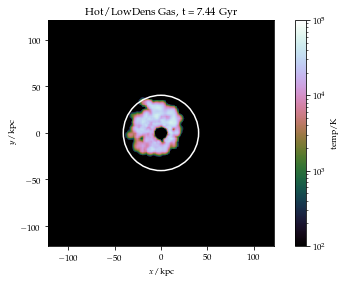

In [190]:
filtered_gas_particles_s1 = h1[haloids[z0haloid][i1]].g[gas_filt]
m_tot = np.sum(filtered_gas_particles_s1.g['mass'].in_units('Msol'))
masses = np.array([float(m_tot)])

t = s1.properties['time'].in_units('Gyr')

print('Centering halo')
pynbody.analysis.angmom.faceon(h1[haloids[z0haloid][i1]])
print('Making plot')


fig, ax = plt.subplots(1,1)
img_width = str(round(rvirs[z0haloid][i1]*6,2)) + ' kpc'
pynbody.plot.sph.image(filtered_gas_particles_s1, width=img_width, subplot=ax, qty='temp', vmin=1e2, vmax=1e5, cmap='cubehelix')#, show_cbar=False)

#img_width = str(round(rvirs[z0haloid][i1]*20,2)) + ' kpc'
#pynbody.plot.sph.image(filtered_gas_particles_s1, width=img_width, subplot=ax[1], vmin=1e-6, vmax=1e6, show_cbar=False)

ax.set_title(f"Hot/LowDens Gas, t = {t:.2f} Gyr")

circle = plt.Circle((0,0),rvirs[z0haloid][i1],color = 'w', linestyle='-', fill=False, linewidth=1.5)
ax.add_artist(circle)
#circle2 = plt.Circle((0,0),rvirs[z0haloid][i1],color = 'w', linestyle='-', fill=False, linewidth=1.5)
#ax[1].add_artist(circle2)

plt.tight_layout()
plt.savefig(f'particle_tracking_plots/h242_{z0haloid}_{snapnums[i1]}.png',dpi=300)
plt.show()

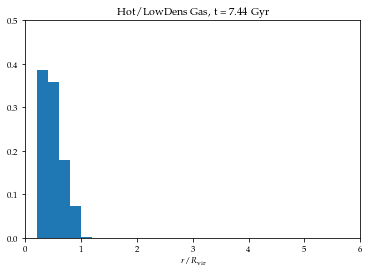

In [191]:
bins = np.arange(0,6,0.2)
rs = filtered_gas_particles_s1.g['r']/rvirs[z0haloid][i1]
plt.hist(rs, bins=bins, weights=np.ones(len(rs)) / len(rs))
plt.xlim(0,6)
plt.ylim(0,0.5)
plt.title(f"Hot/LowDens Gas, t = {t:.2f} Gyr")
plt.xlabel(r'$r / R_{\mathrm{vir}}$')
plt.savefig(f'particle_tracking_histograms/h242_{z0haloid}_{snapnums[i1]}.png',dpi=300)
plt.show()

Snapshot 002304, t = 7.77
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 4510 gas particles, M = 1.17e+08 Msol
	 Centering halo...
	 Making plot...


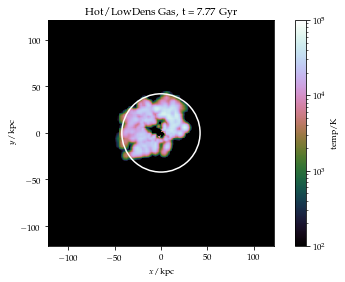

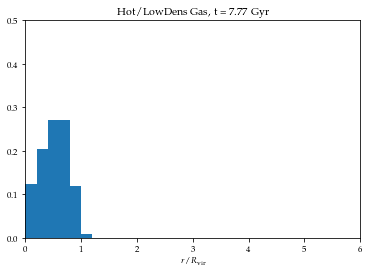

Snapshot 002400, t = 8.09
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 4510 gas particles, M = 1.17e+08 Msol
	 Centering halo...
	 Making plot...


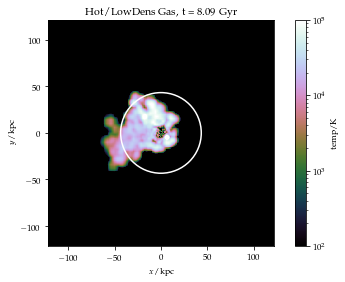

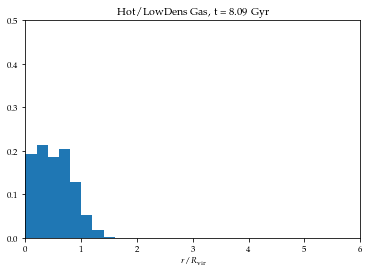

Snapshot 002496, t = 8.41
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 4510 gas particles, M = 1.17e+08 Msol
	 Centering halo...
	 Making plot...


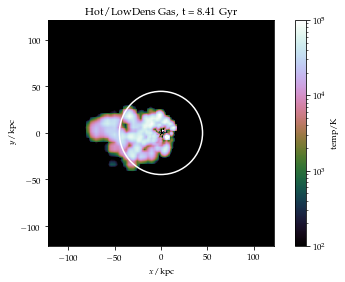

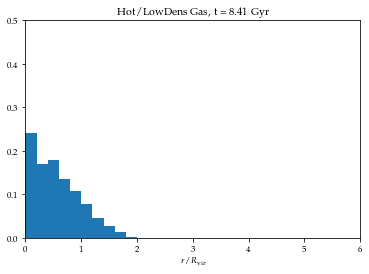

Snapshot 002554, t = 8.61
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 4510 gas particles, M = 1.17e+08 Msol
	 Centering halo...
	 Making plot...


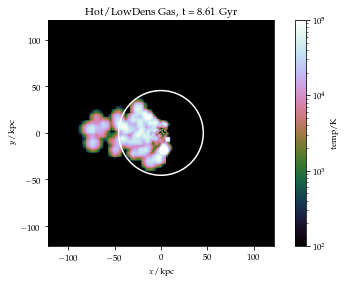

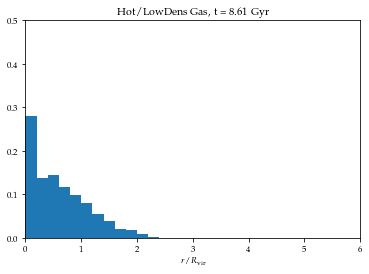

Snapshot 002592, t = 8.74
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 4510 gas particles, M = 1.17e+08 Msol
	 Centering halo...
	 Making plot...


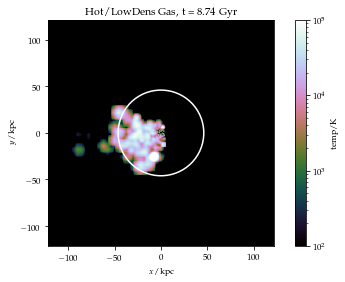

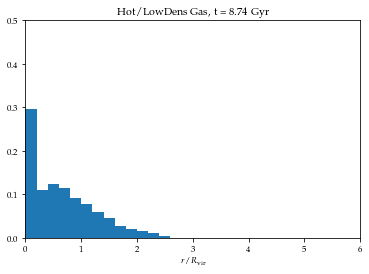

Snapshot 002688, t = 9.06
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 4510 gas particles, M = 1.17e+08 Msol
	 Centering halo...
	 Making plot...


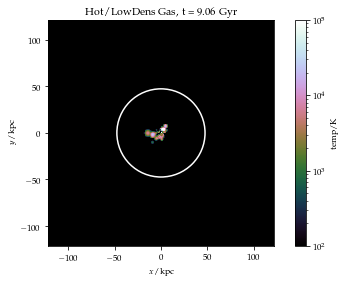

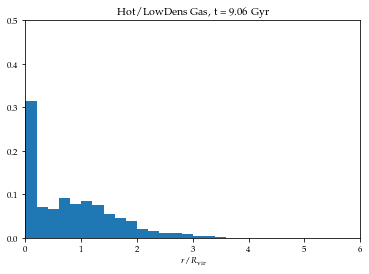

Snapshot 002784, t = 9.38
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 4510 gas particles, M = 1.17e+08 Msol
	 Centering halo...
	 Making plot...


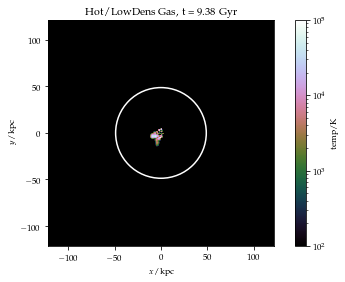

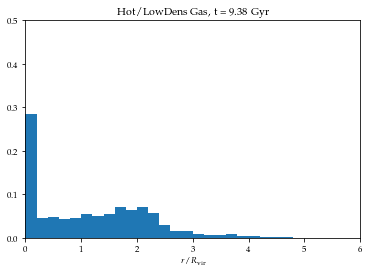

Snapshot 002880, t = 9.71
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 4510 gas particles, M = 1.17e+08 Msol
	 Centering halo...
	 Making plot...


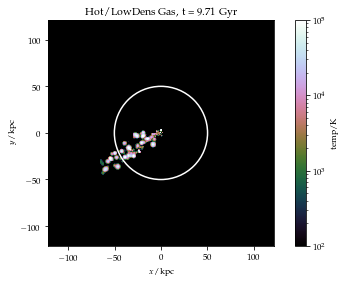

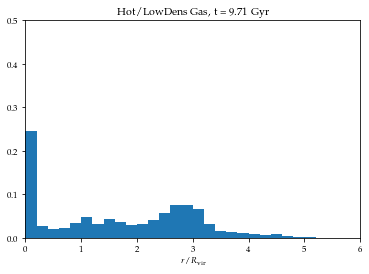

Snapshot 002976, t = 10.03
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 4510 gas particles, M = 1.17e+08 Msol
	 Centering halo...
	 Making plot...


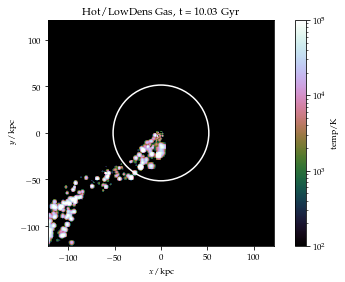

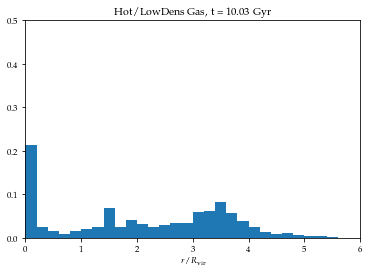

Snapshot 003072, t = 10.35
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 4510 gas particles, M = 1.17e+08 Msol
	 Centering halo...
	 Making plot...


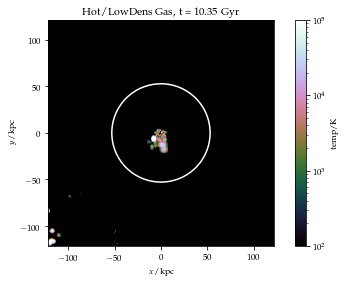

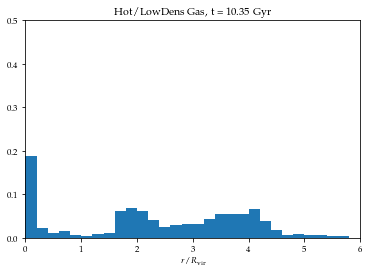

In [192]:
for i in np.flip(np.arange(i1-10,i1,1)):
    f = f_base + snapnums[i]
    s = pynbody.load(f)
    s.physical_units()
    h = s.halos()
    t = s.properties['time'].in_units('Gyr')
    print(f'Snapshot {snapnums[i]}, t = {t:.2f}')
    
    print('\t Creating bridge object...')
    b = pynbody.bridge.OrderBridge(s1,s)
    
    print('\t Identifying gas particles w/ bridge...')
    filtered_gas_particles = b(filtered_gas_particles_s1)

    m_tot = np.sum(filtered_gas_particles.g['mass'].in_units('Msol'))
    masses = np.append(masses, float(m_tot))
    print(f'\t Identified {len(filtered_gas_particles)} gas particles, M = {m_tot:.2e} Msol')

        
    print('\t Centering halo...')
    pynbody.analysis.angmom.faceon(h[haloids[z0haloid][i]])
    
    print('\t Making plot...')
    fig, ax = plt.subplots(1,1)
    
    img_width = str(round(rvirs[z0haloid][i1]*6,2)) + ' kpc' # intentionally left as i1 to keep the size fixed
    pynbody.plot.sph.image(filtered_gas_particles.g, width=img_width, subplot=ax, qty='temp', vmin=1e2, vmax=1e5, cmap='cubehelix')
    
    # img_width = str(round(rvirs[z0haloid][i1]*20,2)) + ' kpc'
    # pynbody.plot.sph.image(filtered_gas_particles.g, width=img_width, subplot=ax[1], vmin=1e-6, vmax=1e6, show_cbar=False)
    
    ax.set_title(f"Hot/LowDens Gas, t = {t:.2f} Gyr")

    circle = plt.Circle((0,0),rvirs[z0haloid][i],color = 'w', linestyle='-', fill=False, linewidth=1.5)
    ax.add_artist(circle)
    #circle2 = plt.Circle((0,0),rvirs[z0haloid][i],color = 'w', linestyle='-', fill=False, linewidth=1.5)
    #ax[1].add_artist(circle2)
    
    plt.tight_layout()
    plt.savefig(f'particle_tracking_plots/h242_{z0haloid}_{snapnums[i]}.png',dpi=300)
    plt.show()
    
    bins = np.arange(0,6,0.2)
    rs = filtered_gas_particles.g['r']/rvirs[z0haloid][i]
    plt.figure()
    plt.hist(rs, bins=bins, weights=np.ones(len(rs)) / len(rs))
    plt.xlim(0,6)
    plt.ylim(0,0.5)
    plt.title(f"Hot/LowDens Gas, t = {t:.2f} Gyr")
    plt.xlabel(r'$r / R_{\mathrm{vir}}$')
    plt.savefig(f'particle_tracking_histograms/h242_{z0haloid}_{snapnums[i]}.png',dpi=300)
    plt.show()

In [193]:
import imageio
from os import listdir

filenames = listdir('particle_tracking_plots/')
filenames.sort()
filenames = np.array(filenames)
filenames = filenames[filenames!='.ipynb_checkpoints']
images = []

for filename in filenames:
    images.append(imageio.imread('particle_tracking_plots/'+filename))
imageio.mimsave('h242_80_movie.gif', images, duration=1)

# Following pre-infall halo gas fractions

In [422]:
age = 13.800797497330507
s = 'h242'
z0haloid = 80
i1 = 20 # starting snapshot index

f_base = f'/home/christenc/Data/Sims/{s}.cosmo50PLK.3072g/{s}.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/{s}.cosmo50PLK.3072gst5HbwK1BH.'

f1 = f_base + snapnums[i1]
s1 = pynbody.load(f1)
s1.physical_units()
h1 = s1.halos()
t = s1.properties['time'].in_units('Gyr')
print(f'Snapshot {snapnums[i1]}, t = {t:.2f}')


gas_hot_filt = pynbody.filt.HighPass('temp', 1e4) # select all gas particles with T > 1e4 K
gas_lowdens_filt = pynbody.filt.LowPass('rho',2453000) # select all gas particles with rho < 0.1 amu/cc (converted into Msol/kpc**3)
gas_radial_filt = pynbody.filt.HighPass('r', 0.2*rvirs[z0haloid][i1])
gas_filt = gas_hot_filt & gas_lowdens_filt & gas_radial_filt

pynbody.analysis.halo.center(h1[haloids[z0haloid][i1]])

filtered_gas_particles_s1 = h1[haloids[z0haloid][i1]].g[gas_filt]

Snapshot 002496, t = 8.41


In [431]:
coolontime = filtered_gas_particles_s1.g['coolontime']
difference = coolontime-t
# len(difference[difference>0])/len(difference)
# coolontime.in_units('Gyr')
filtered_gas_particles_s1.g['iord']

SimArray([ 1335600,  2833142,  2833249, ...,  9947769, 10043145, 10056729])

In [423]:
m_tot = np.sum(filtered_gas_particles_s1.g['mass'].in_units('Msol'))
m = filtered_gas_particles_s1.g['mass'].in_units('Msol')
temp = filtered_gas_particles_s1.g['temp'].in_units('K')
rho = filtered_gas_particles_s1.g['rho'].in_units('Msol kpc**-3')
rvir = rvirs[z0haloid][i1]
r = filtered_gas_particles_s1.g['r'].in_units('kpc') / rvir

frac_hot = np.sum(m[(temp > 1e4) & (rho < 2453000) & (r < 1)])/m_tot
frac_disk = np.sum(m[(temp < 1e4) & (rho > 2453000) & (r < 0.2)])/m_tot
frac_stripped = np.sum(m[r > 1])/m_tot

frac_cool_halo = np.sum(m[(temp < 1e4) & (r < 1) & (r > 0.2)])/m_tot
frac_dense_halo = np.sum(m[(rho > 2453000) & (r < 1) & (r > 0.2)])/m_tot
frac_cooldense_halo = np.sum(m[(temp < 1e4) & (rho > 2453000) & (r < 1) & (r > 0.2)])/m_tot

print(f'Hot gas: {frac_hot*100:.2f}%')
print(f'Cool gas in atomic disk: {frac_disk*100:.2f}%')
print(f'Gas stripped away: {frac_stripped*100:.2f}%')
print(f'Total: {(frac_hot+frac_disk+frac_stripped)*100:.2f}%')

Hot gas: 100.00%
Cool gas in atomic disk: 0.00%
Gas stripped away: 0.00%
Total: 100.00%


In [210]:
snapnumbers = [snapnums[i1]]
ts = [t]
fracs_hot = [frac_hot]
fracs_disk = [frac_disk]
fracs_stripped = [frac_stripped]
fracs_cool_halo = [frac_cool_halo]
fracs_dense_halo = [frac_dense_halo]
fracs_cooldense_halo = [frac_cooldense_halo]

In [211]:
for i in np.flip(np.arange(i1-19,i1,1)):
    f = f_base + snapnums[i]
    s = pynbody.load(f)
    s.physical_units()
    h = s.halos()
    t = s.properties['time'].in_units('Gyr')
    print(f'Snapshot {snapnums[i]}, t = {t:.2f}')
    snapnumbers.append(snapnums[i])
    ts.append(t)
    
    print('\t Creating bridge object...')
    b = pynbody.bridge.OrderBridge(s1,s)
    
    print('\t Identifying gas particles w/ bridge...')
    filtered_gas_particles = b(filtered_gas_particles_s1)
    print(f'\t Identified {len(filtered_gas_particles)} gas particles, M = {m_tot:.2e} Msol')
    
    print('\t Centering halo... ')
    pynbody.analysis.halo.center(h[haloids[z0haloid][i]])
    
    m_tot = np.sum(filtered_gas_particles.g['mass'].in_units('Msol'))
    m = filtered_gas_particles.g['mass'].in_units('Msol')
    temp = filtered_gas_particles.g['temp'].in_units('K')
    rho = filtered_gas_particles.g['rho'].in_units('Msol kpc**-3')
    rvir = rvirs[z0haloid][i]
    r = filtered_gas_particles.g['r'].in_units('kpc') / rvir

    frac_hot = np.sum(m[(temp > 1e4) & (rho < 2453000) & (r < 1)])/m_tot
    frac_disk = np.sum(m[(temp < 1e4) & (rho > 2453000) & (r < 0.2)])/m_tot
    frac_stripped = np.sum(m[r > 1])/m_tot
    frac_cool_halo = np.sum(m[(temp < 1e4) & (r < 1) & (r > 0.2)])/m_tot
    frac_dense_halo = np.sum(m[(rho > 2453000) & (r < 1) & (r > 0.2)])/m_tot
    frac_cooldense_halo = np.sum(m[(temp < 1e4) & (rho > 2453000) & (r < 1) & (r > 0.2)])/m_tot
    
    fracs_hot.append(frac_hot)
    fracs_disk.append(frac_disk)
    fracs_stripped.append(frac_stripped)
    fracs_cool_halo.append(frac_cool_halo)
    fracs_dense_halo.append(frac_dense_halo)
    fracs_cooldense_halo.append(frac_cooldense_halo)

Snapshot 002554, t = 8.61
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 2162 gas particles, M = 5.58e+07 Msol
	 Centering halo... 
Snapshot 002592, t = 8.74
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 2162 gas particles, M = 5.58e+07 Msol
	 Centering halo... 
Snapshot 002688, t = 9.06
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 2162 gas particles, M = 5.58e+07 Msol
	 Centering halo... 
Snapshot 002784, t = 9.38
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 2161 gas particles, M = 5.58e+07 Msol
	 Centering halo... 
Snapshot 002880, t = 9.71
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 2161 gas particles, M = 5.57e+07 Msol
	 Centering halo... 
Snapshot 002976, t = 10.03
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 2161 gas particles, M = 5.57e+07 Msol
	 Centering halo..

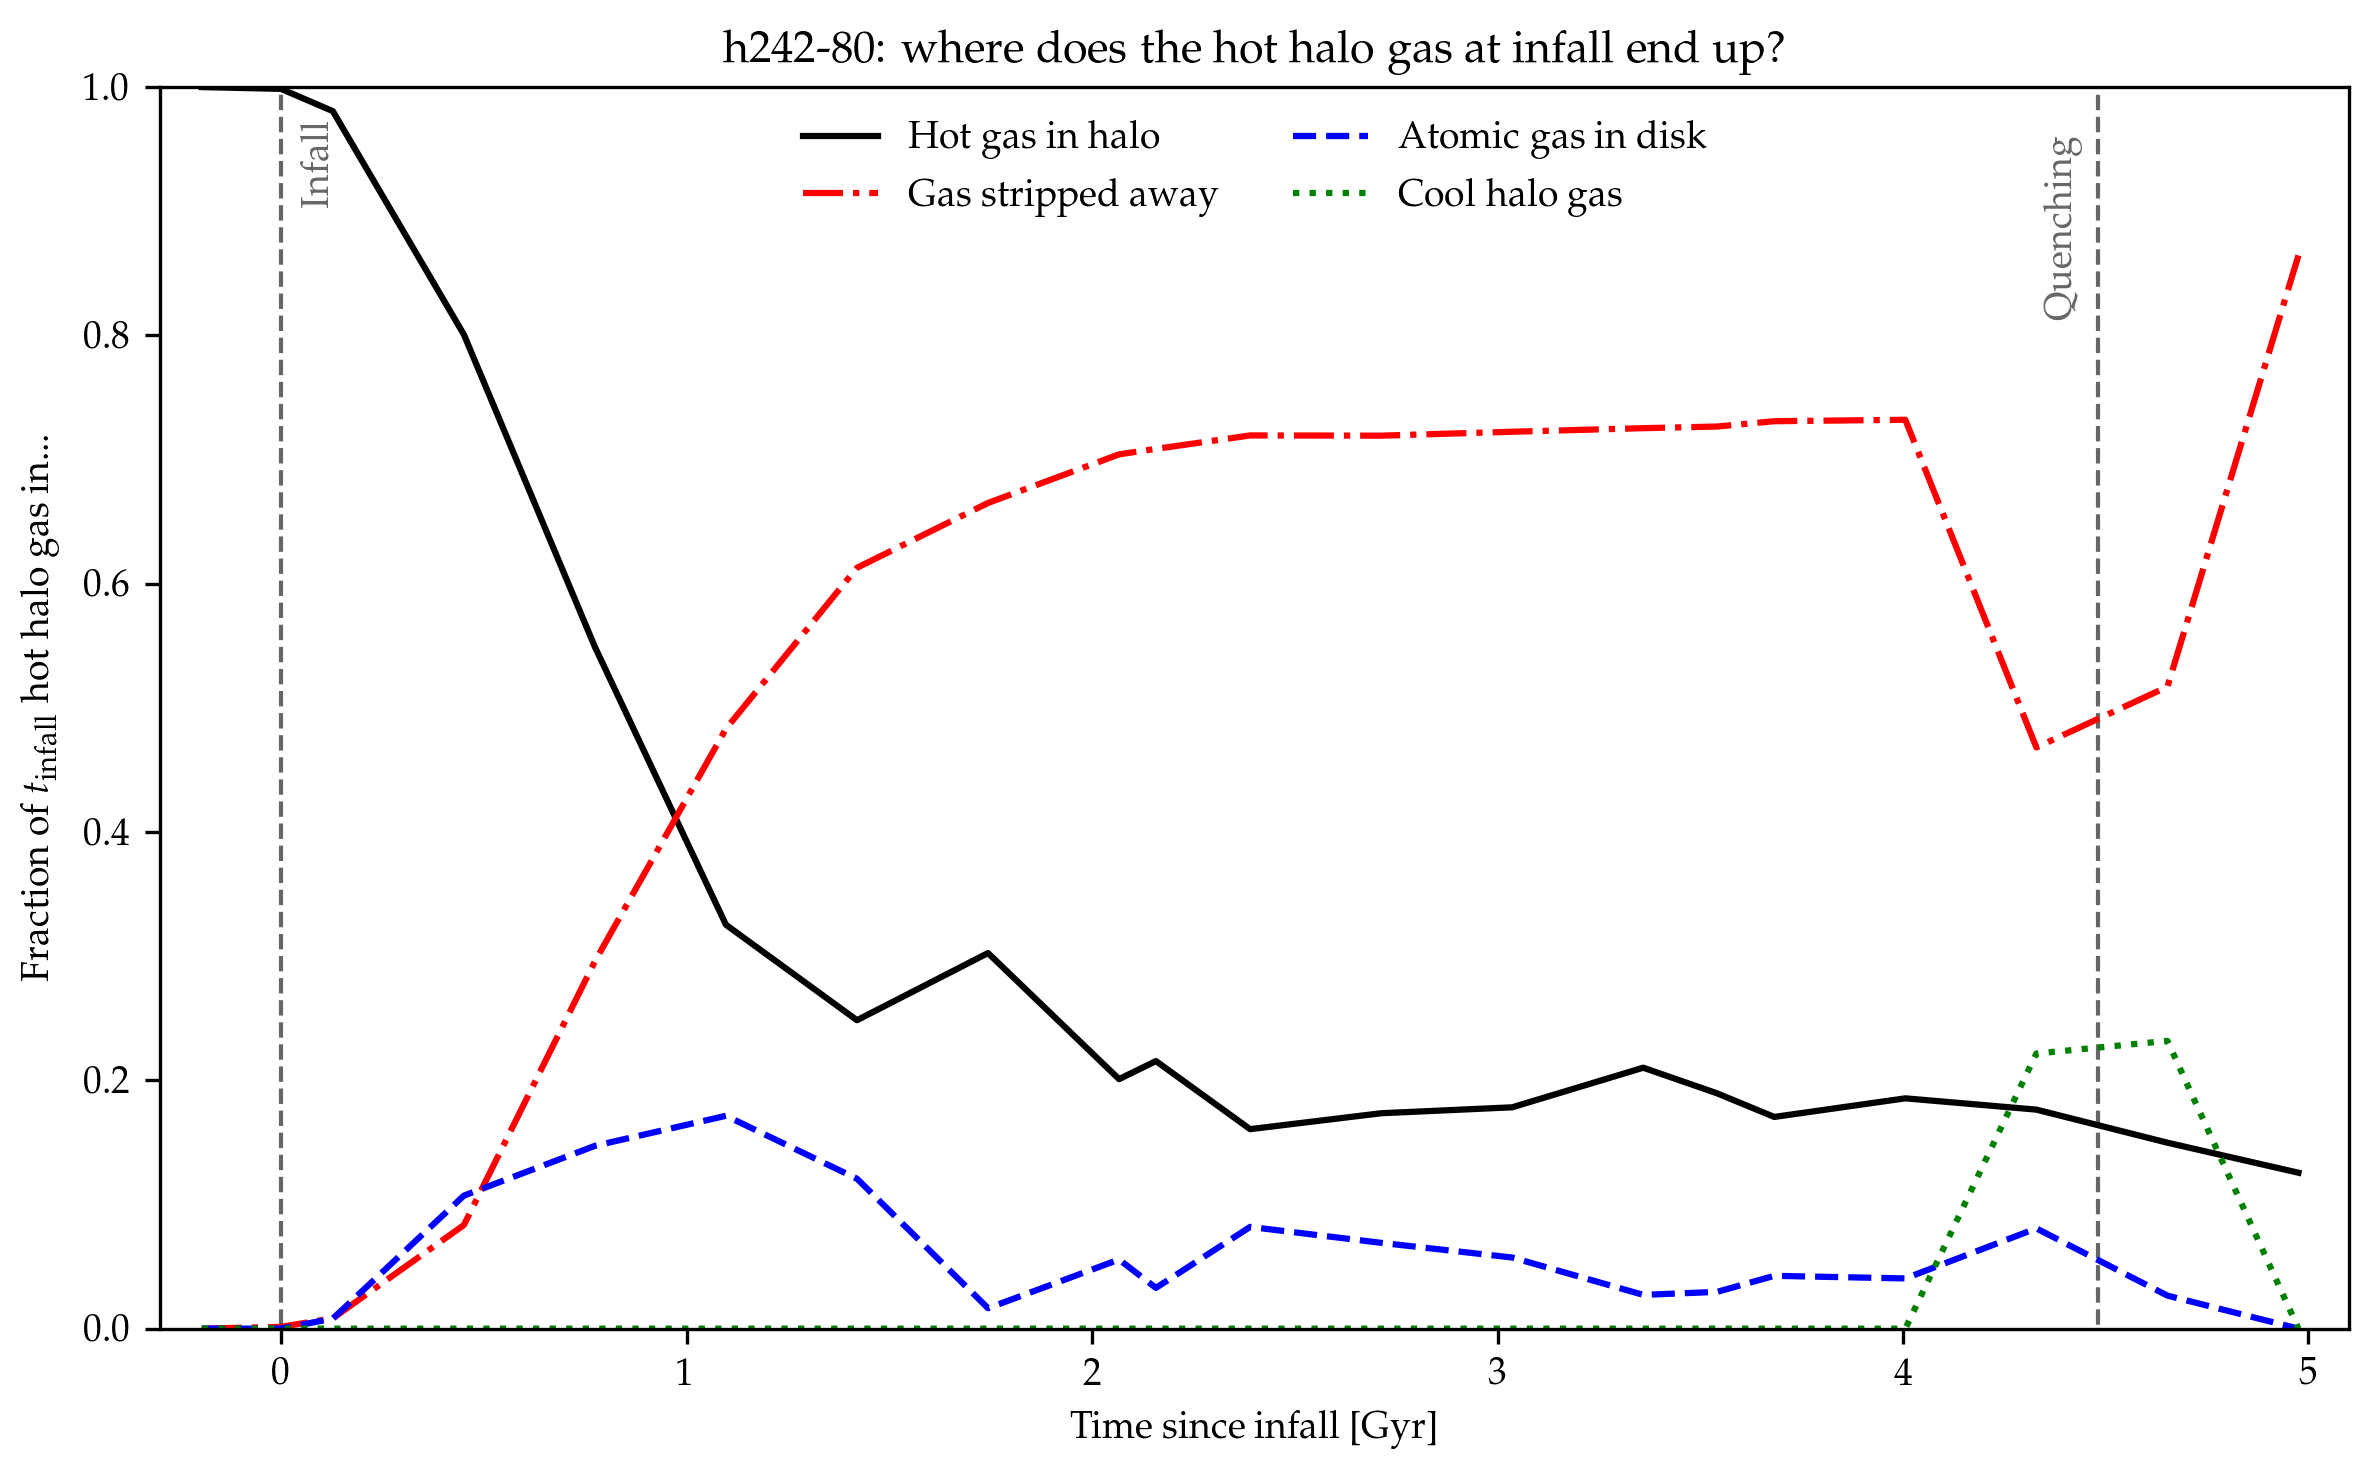

In [216]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(8,5))

frac_hot = np.array(fracs_hot)
frac_disk = np.array(fracs_disk)
frac_stripped = np.array(fracs_stripped)
frac_cool_halo = np.array(fracs_cool_halo)
frac_dense_halo = np.array(fracs_dense_halo)
frac_cooldense_halo = np.array(fracs_cooldense_halo)

t = np.array(ts) - 8.61

ax.plot(t, frac_hot, 'k-', label='Hot gas in halo')

ax.plot(t, frac_stripped, 'r-.', label='Gas stripped away')

ax.plot(t, frac_disk, 'b--', label='Atomic gas in disk')
ax.plot(t, frac_cool_halo, 'g:', label='Cool halo gas')

ax.set_ylim(0, 1)
ax.set_xlim(-0.3,5.1)
ax.legend(frameon=False,ncol=2)

ax.plot([0,0],[-0.05,1.05], 'k--', alpha=0.6, zorder=0,linewidth=1)
ax.annotate('Infall',(0.05,0.91),alpha=0.6, rotation='vertical')
ax.plot([4.48,4.48],[-0.05,1.05],'k--', alpha=0.6, zorder=0,linewidth=1)
ax.annotate(r'Quenching',(4.35,0.82),alpha=0.6, rotation='vertical')

ax.set_xlabel('Time since infall [Gyr]')
ax.set_ylabel('Fraction of $t_{\mathrm{infall}}$ hot halo gas in...')
ax.set_title('h242-80: where does the hot halo gas at infall end up?')

plt.tight_layout()
# plt.savefig('h242_80_hot_gas_fractions.png',dpi=300)
plt.show()

# Some Debugging

In [123]:
age = 13.800797497330507
s = 'h242'
z0haloid = 80

i1 = 20 # starting snapshot index

f_base = f'/home/christenc/Data/Sims/{s}.cosmo50PLK.3072g/{s}.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/{s}.cosmo50PLK.3072gst5HbwK1BH.'

f1 = f_base + snapnums[i1]
s1 = pynbody.load(f1)
s1.physical_units()
h1 = s1.halos()
f2 = f_base + snapnums[i1-1]
s2 = pynbody.load(f2)
s2.physical_units()
h2 = s2.halos()

gas_cool_filt = pynbody.filt.LowPass('temp', 1e4) # select all gas particles with T > 1e4 K
gas_highdens_filt = pynbody.filt.HighPass('rho',2453000) # select all gas particles with rho < 0.1 amu/cc (converted into Msol/kpc**3)
gas_radial_filt = pynbody.filt.LowPass('r', 0.2*rvirs[z0haloid][i1])
gas_filt = gas_cool_filt & gas_highdens_filt & gas_radial_filt

In [124]:
b = pynbody.bridge.OrderBridge(s1, s2)

In [125]:
halo = h1[1]
halo

<SimSnap "/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h242.cosmo50PLK.3072gst5HbwK1BH.002496:halo_1" len=36665612>

In [127]:
len(halo.s), len(halo.g)

(14625496, 3439465)

In [128]:
halo2 = b(halo)
halo2

<SimSnap "/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h242.cosmo50PLK.3072gst5HbwK1BH.002554:indexed" len=36617445>

In [129]:
len(halo2.s), len(halo2.g)

(14625496, 3391298)

In [133]:
pynbody.analysis.halo.center(halo)

In [134]:
filt = pynbody.filt.LowPass('r', 10)
halo_filt = halo[filt]
halo_filt

<SimSnap "/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h242.cosmo50PLK.3072gst5HbwK1BH.002496:halo_1:lowpass_r" len=12942461>

In [135]:
len(halo_filt.s), len(halo_filt.g)

(11030065, 378552)

In [136]:
filt1 = pynbody.filt.LowPass('r', 10)
filt2 = pynbody.filt.LowPass('r', 5)
filt = filt1 & filt2
halo_filt = halo[filt]
halo_filt

<SimSnap "/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h242.cosmo50PLK.3072gst5HbwK1BH.002496:halo_1:lowpass_r&lowpass_r" len=10360025>

In [137]:
len(halo_filt.s), len(halo_filt.g)

(9512969, 133770)

In [158]:
b = pynbody.bridge.OrderBridge(s1, s2)#, allow_family_change=True, monotonic=False)

In [155]:
halo_filt2 = b(halo_filt)

In [156]:
len(halo_filt2.s), len(halo_filt2.g)

(9512969, 118494)

In [152]:
?b

Signature:      b(s)
Type:           OrderBridge
String form:    <pynbody.bridge.OrderBridge object at 0x7f6b5b304438>
File:           ~/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/bridge/__init__.py
Docstring:     
An OrderBridge uses integer arrays in two simulations
(start,end) where particles i_start and i_end are
defined to be the same if and only if
start[order_array][i_start] == start[order_array][i_end].

If monotonic is True, order_array must be monotonically increasing
in both ends of the bridge (and this is not checked for you). If
monotonic is False, the bridging is slower but this is the
failsafe option.
Call docstring:
Given a subview of either the start or end point of the bridge,
generate the corresponding subview of the connected snapshot


# Following pre-infall COLD gas fractions

In [178]:
age = 13.800797497330507
s = 'h242'
z0haloid = 80

i1 = 20 # starting snapshot index

f_base = f'/home/christenc/Data/Sims/{s}.cosmo50PLK.3072g/{s}.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/{s}.cosmo50PLK.3072gst5HbwK1BH.'

f1 = f_base + snapnums[i1]
s1 = pynbody.load(f1)
s1.physical_units()
h1 = s1.halos()
t = s1.properties['time'].in_units('Gyr')
print(f'Snapshot {snapnums[i1]}, t = {t:.2f}')


gas_cool_filt = pynbody.filt.LowPass('temp', 1e4) # select all gas particles with T > 1e4 K
gas_highdens_filt = pynbody.filt.HighPass('rho',2453000) # select all gas particles with rho < 0.1 amu/cc (converted into Msol/kpc**3)
gas_radial_filt = pynbody.filt.LowPass('r', 0.2*rvirs[z0haloid][i1])
gas_filt = gas_cool_filt & gas_highdens_filt & gas_radial_filt

pynbody.analysis.halo.center(h1[haloids[z0haloid][i1]])

filtered_gas_particles_s1 = h1[haloids[z0haloid][i1]].g[gas_filt]

Snapshot 002496, t = 8.41


In [179]:
m_tot = np.sum(filtered_gas_particles_s1['mass'].in_units('Msol'))
m = filtered_gas_particles_s1['mass'].in_units('Msol')

temp = filtered_gas_particles_s1.g['temp'].in_units('K')
rho = filtered_gas_particles_s1.g['rho'].in_units('Msol kpc**-3')
rvir = rvirs[z0haloid][i1]
r = filtered_gas_particles_s1.g['r'].in_units('kpc') / rvir

frac_hot = np.sum(m[(temp > 1e4) & (rho < 2453000) & (r < 1)])/m_tot
frac_disk = np.sum(m[(temp < 1e4) & (rho > 2453000) & (r < 0.2)])/m_tot
frac_stripped = np.sum(m[r > 1])/m_tot

m_tot_init = m_tot
frac_stars = 1 - (m_tot / m_tot_init)


print(f'Hot gas: {frac_hot*100:.2f}%')
print(f'Cool disk gas: {frac_disk*100:.2f}%')
print(f'Gas stripped away: {frac_stripped*100:.2f}%')
print(f'Formed stars: {frac_stars*100:.2f}%')
print(f'Total: {(frac_hot+frac_disk+frac_stripped+frac_stars)*100:.2f}%')

Hot gas: 0.00%
Cool disk gas: 100.00%
Gas stripped away: 0.00%
Formed stars: 0.00%
Total: 100.00%


In [180]:
snapnumbers = [snapnums[i1]]
ts = [t]
fracs_hot = [frac_hot]
fracs_disk = [frac_disk]
fracs_stripped = [frac_stripped]
fracs_stars = [frac_stars]

In [181]:
for i in np.flip(np.arange(i1-19,i1,1)):
    f = f_base + snapnums[i]
    s = pynbody.load(f)
    s.physical_units()
    h = s.halos()
    t = s.properties['time'].in_units('Gyr')
    print(f'Snapshot {snapnums[i]}, t = {t:.2f}')
    snapnumbers.append(snapnums[i])
    ts.append(t)
    
    print('\t Creating bridge object...')
    b = pynbody.bridge.OrderBridge(s1,s)
    
    print('\t Identifying gas particles w/ bridge...')
    filtered_gas_particles = b(filtered_gas_particles_s1)
    print(f'\t Identified {len(filtered_gas_particles)} gas/star particles, M = {m_tot:.2e} Msol')
    
    print('\t Centering halo... ')
    pynbody.analysis.halo.center(h[haloids[z0haloid][i]])
    
    m_tot = np.sum(filtered_gas_particles['mass'].in_units('Msol'))
    m = filtered_gas_particles['mass'].in_units('Msol')

    temp = filtered_gas_particles.g['temp'].in_units('K')
    rho = filtered_gas_particles.g['rho'].in_units('Msol kpc**-3')
    rvir = rvirs[z0haloid][i]
    r = filtered_gas_particles.g['r'].in_units('kpc') / rvir

    frac_hot = np.sum(m[(temp > 1e4) & (rho < 2453000) & (r < 1)])/m_tot
    frac_disk = np.sum(m[(temp < 1e4) & (rho > 2453000) & (r < 0.2)])/m_tot
    frac_stripped = np.sum(m[r > 1])/m_tot
    frac_stars = 1 - (m_tot / m_tot_init)
    
    print(f'Hot: {frac_hot:.2f}, Disk: {frac_disk:.2f}, Stripped: {frac_stripped:.2f}, Stars: {frac_stars:.2f}')
    
    fracs_hot.append(frac_hot)
    fracs_disk.append(frac_disk)
    fracs_stars.append(frac_stars)
    fracs_stripped.append(frac_stripped)

Snapshot 002554, t = 8.61
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 1738 gas/star particles, M = 4.51e+07 Msol
	 Centering halo... 
Hot: 0.45, Disk: 0.51, Stripped: 0.00, Stars: 0.00
Snapshot 002592, t = 8.74
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 1738 gas/star particles, M = 4.51e+07 Msol
	 Centering halo... 
Hot: 0.44, Disk: 0.52, Stripped: 0.00, Stars: 0.00
Snapshot 002688, t = 9.06
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 1738 gas/star particles, M = 4.50e+07 Msol
	 Centering halo... 
Hot: 0.54, Disk: 0.43, Stripped: 0.00, Stars: 0.01
Snapshot 002784, t = 9.38
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 1737 gas/star particles, M = 4.48e+07 Msol
	 Centering halo... 
Hot: 0.57, Disk: 0.38, Stripped: 0.02, Stars: 0.01
Snapshot 002880, t = 9.71
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 

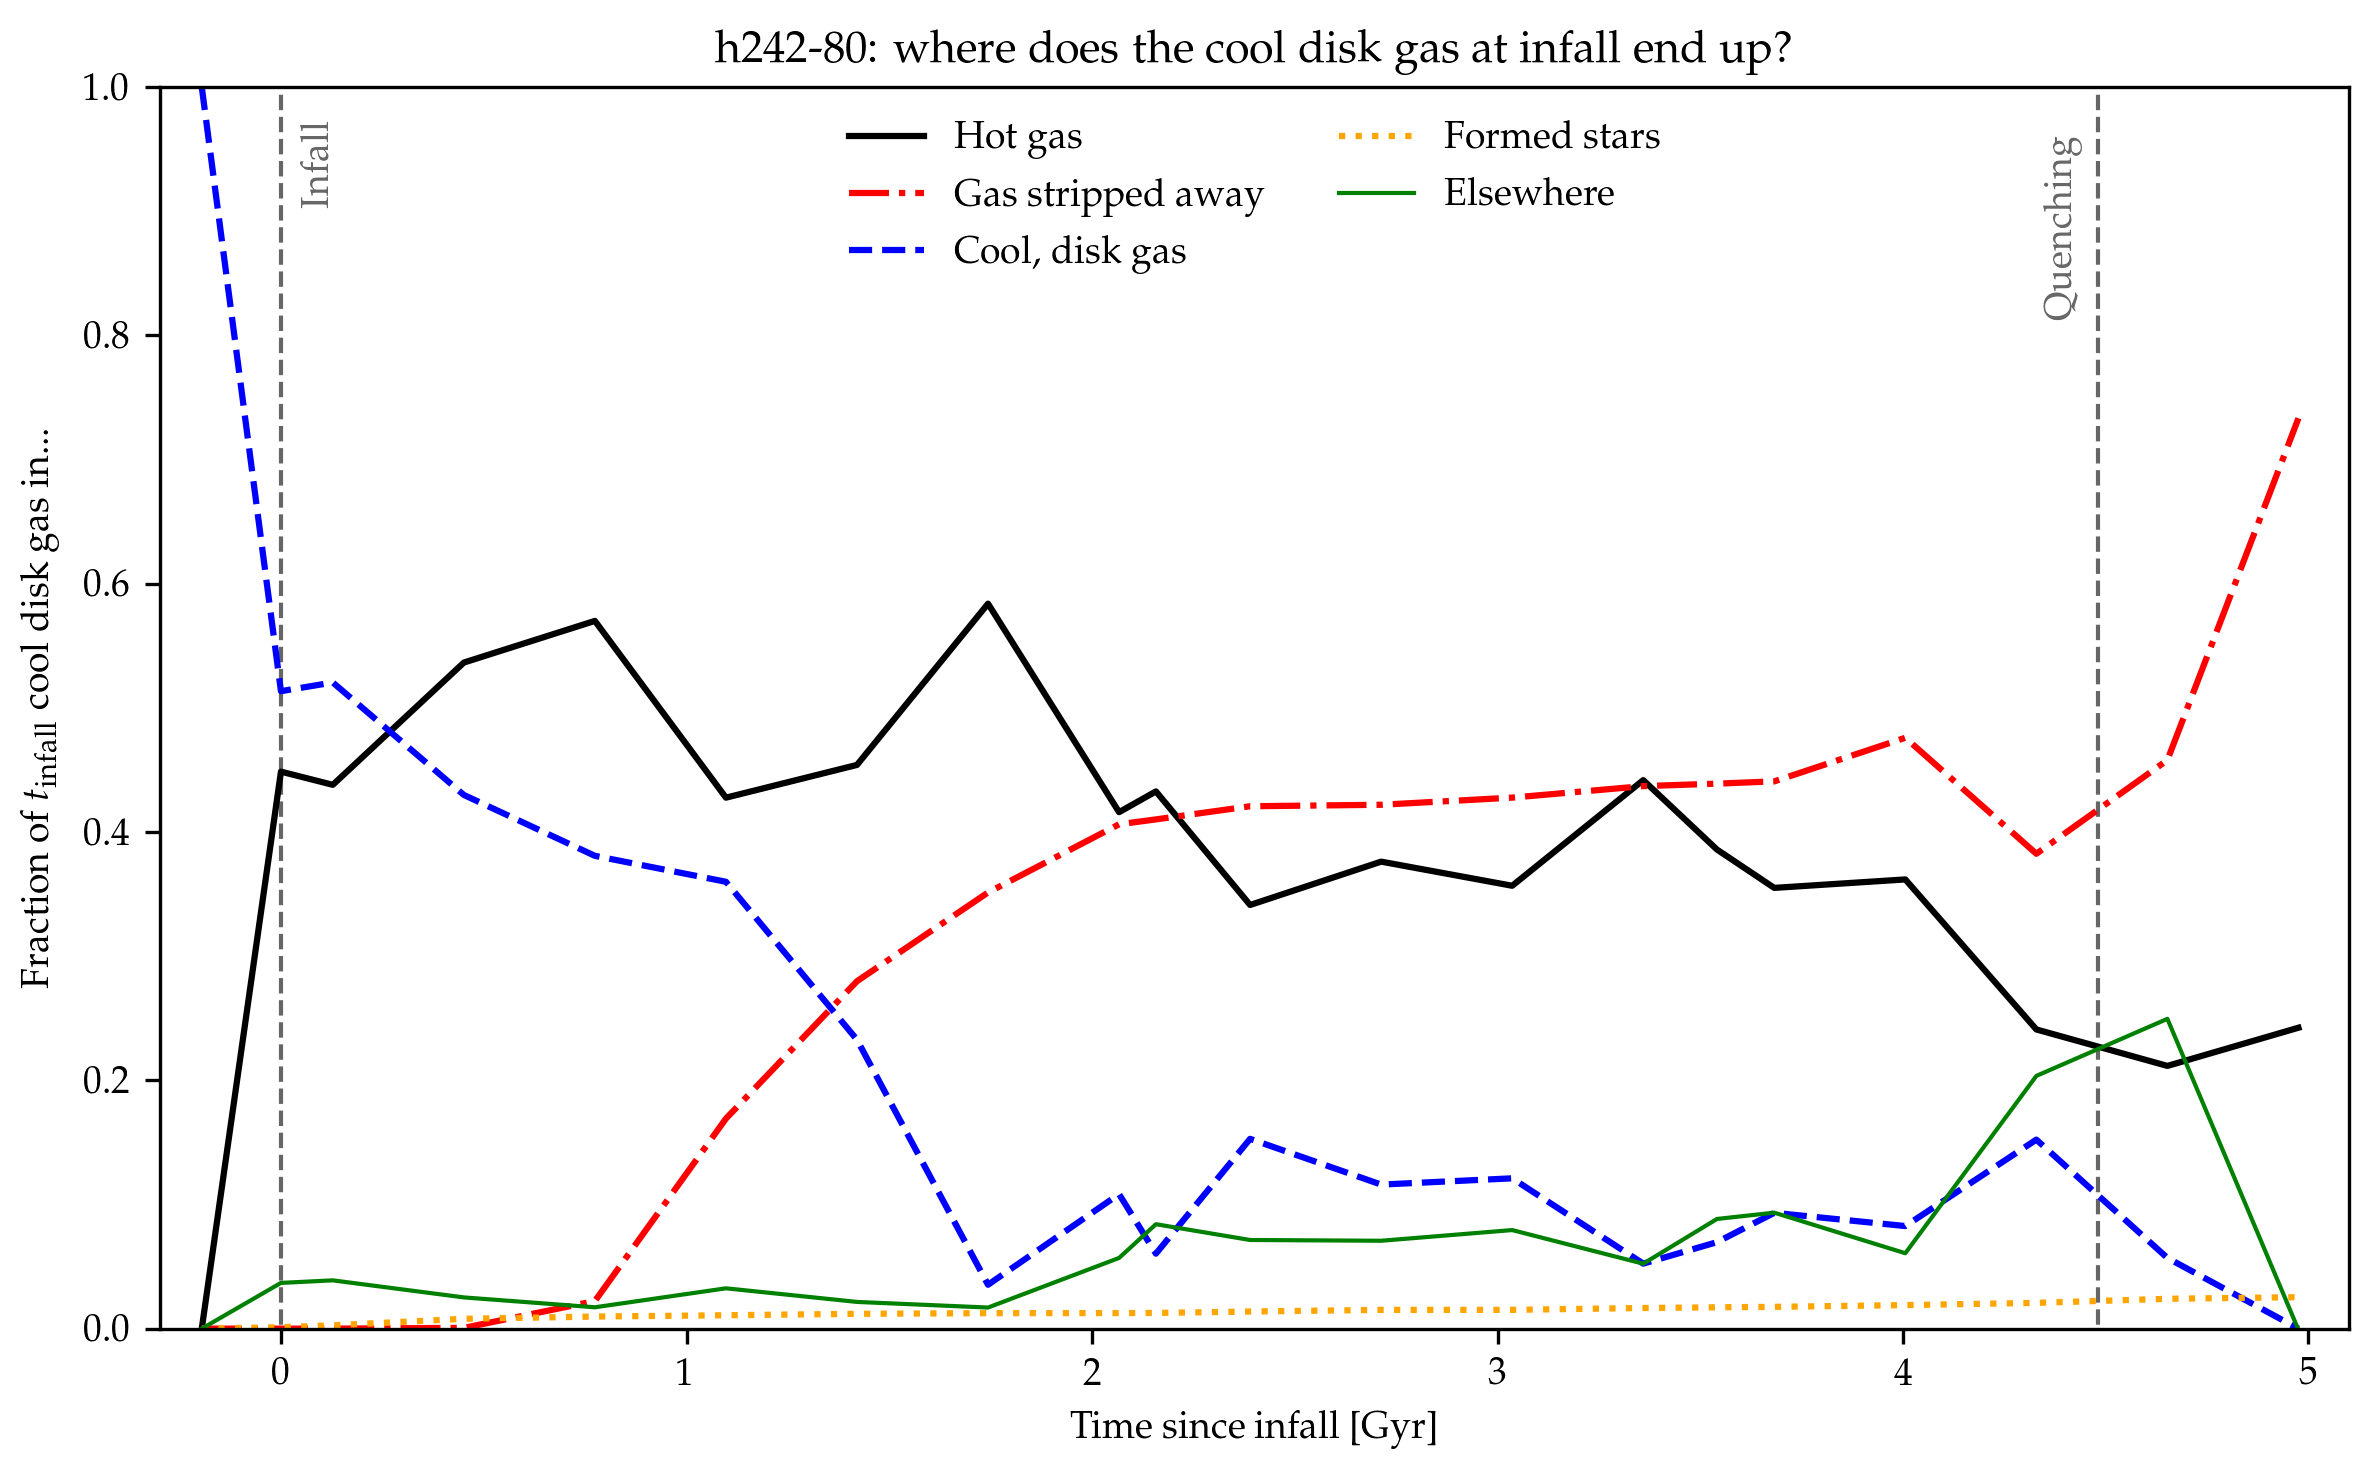

In [182]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(8,5))

frac_hot = np.array(fracs_hot)
frac_disk = np.array(fracs_disk)
frac_stars = np.array(fracs_stars)
frac_stripped = np.array(fracs_stripped)
t = np.array(ts) - 8.61

ax.plot(t, frac_hot, 'k-', label='Hot gas')

ax.plot(t, frac_stripped, 'r-.', label='Gas stripped away')

ax.plot(t, frac_disk, 'b--', label='Cool, disk gas')
ax.plot(t, frac_stars, ':', color='orange', label='Formed stars')

ax.plot(t, 1-frac_hot-frac_stripped-frac_disk-frac_stars, 'g-', label='Elsewhere', linewidth=1)

ax.set_ylim(0, 1)
ax.set_xlim(-0.3,5.1)
ax.legend(frameon=False,ncol=2)

ax.plot([0,0],[-0.05,1.05], 'k--', alpha=0.6, zorder=0,linewidth=1)
ax.annotate('Infall',(0.05,0.91),alpha=0.6, rotation='vertical')
ax.plot([4.48,4.48],[-0.05,1.05],'k--', alpha=0.6, zorder=0,linewidth=1)
ax.annotate(r'Quenching',(4.35,0.82),alpha=0.6, rotation='vertical')

ax.set_xlabel('Time since infall [Gyr]')
ax.set_ylabel('Fraction of $t_{\mathrm{infall}}$ cool disk gas in...')
ax.set_title('h242-80: where does the cool disk gas at infall end up?')

plt.tight_layout()
plt.savefig('h242_80_cold_gas_fractions.png',dpi=300)
plt.show()

# Scaling this Up

In [183]:
data = read_timescales()
data = data[(data.quenched==True)]
data['timescale'] = data.tinfall - data.tquench
data = data[(data.timescale > 3)]
data

,M_star,haloid,n_star,quenched,sim,tinfall,tinfall_lower,tinfall_upper,tquench,tquench_lower,tquench_upper,timescale
12,8.417204e+07,28,16982,True,h148,7.326666,7.326666,7.326666,0.711615,1.742898,0.092845,6.615052
16,5.759679e+06,37,1159,True,h148,4.740784,4.740784,4.740784,0.250474,0.250474,0.250474,4.490310
24,2.822993e+06,68,568,True,h148,5.602745,5.602745,5.191967,1.089320,1.089320,1.089320,4.513425
63,2.352154e+07,80,4760,True,h242,5.191967,5.191967,5.064019,0.705483,0.900994,0.705483,4.486484
72,3.338275e+06,20,672,True,h229,5.387255,5.710490,5.191967,0.340459,0.340459,0.340459,5.046795
73,7.714878e+07,22,15673,True,h229,9.589313,9.589313,6.033725,5.183798,5.183798,2.549277,4.405516


### WILL NEED TO LIST THESE FOR EACH SIM

In [184]:
snapnums = ['004096', '004032', '003936', '003840', '003744', '003648', '003606', '003552', '003456', '003360', '003264', '003195', '003168', '003072','002976', '002880', '002784', '002688', '002592', '002554', '002496', '002400', '002304','002208', '002112', '002088', '002016', '001920', '001824','001740','001728','001632', '001536', '001475', '001440', '001344', '001269', '001248','001152', '001106', '001056', '000974', '000960','000864', '000776', '000768', '000672', '000637', '000576', '000480', '000456', '000384', '000347', '000288', '000275', '000225', '000192', '000188', '000139', '000107', '000096', '000071']

haloids = {
    1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 4, 4, 4, 2],
    10: [10, 10, 9, 7, 7, 8, 7, 7, 7, 4, 5, 5, 5, 6, 6, 4, 3, 3, 3, 3, 3, 4, 5, 5, 6, 6, 4, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 6, 9, 9, 9, 10, 10, 9, 13, 14, 16, 18, 18, 18, 20],
    12: [12, 12, 12, 9, 10, 11, 10, 10, 10, 9, 10, 6, 6, 5, 4, 3, 4, 4, 4, 4, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 4, 4, 4, 4, 4, 5, 6, 6, 7, 8, 8, 8, 8, 10, 11, 10, 7, 6, 11, 11, 7, 11, 11, 9, 5, 6, 9],
    24: [24, 24, 25, 26, 25, 25, 25, 24, 24, 23, 24, 25, 24, 22, 22, 22, 21, 20, 19, 19, 19, 19, 19, 20, 19, 19, 17, 20, 21, 21, 20, 21, 17, 16, 17, 15, 15, 16, 15, 18, 17, 17, 17, 20, 21, 21, 20, 21, 24, 26, 28, 25, 24, 27, 29, 23, 20, 19, 14, 12, 16, 17],
    30: [30, 29, 29, 31, 29, 28, 29, 29, 30, 32, 30, 29, 28, 26, 25, 24, 22, 22, 20, 20, 20, 21, 21, 22, 21, 21, 18, 19, 18, 17, 16, 17, 15, 13, 14, 12, 13, 14, 13, 13, 13, 14, 14, 13, 15, 15, 14, 15, 16, 16, 17, 18, 16, 14, 12, 8, 9, 9, 8, 6, 5, 4],
    34: [34, 33, 34, 36, 35, 35, 34, 34, 35, 36, 33, 33, 33, 33, 33, 33, 33, 32, 32, 32, 32, 31, 31, 30, 30, 31, 28],
    40: [40, 40, 41, 44, 41, 41, 42, 41, 42, 42, 40, 39, 40, 39, 38, 38, 38, 38, 38, 38, 39, 38, 37, 38, 38, 38, 37, 36, 37, 35, 34, 34, 34, 32, 33, 34, 32, 34, 35, 38, 40, 38, 38, 42, 38, 38, 39, 40, 45, 50, 49, 49, 52, 57, 55, 50, 40, 41, 31, 25, 26],
    41: [41, 41, 42, 43, 44, 29, 26, 23, 20, 19, 19, 19, 19, 18, 18, 18, 19, 18, 18, 18, 18, 20, 20, 21, 22, 22, 21, 23, 28, 28, 28, 27, 29, 27, 28, 29, 27, 29, 32, 34, 35, 29, 29, 28, 26, 26, 34, 43, 121, 121, 115, 101, 103, 87, 82, 77, 122, 156, 122],
    44: [44, 44, 45, 48, 46, 45, 47, 46, 48, 50, 48, 50, 53, 51, 51, 52, 50, 52, 52, 53, 51, 51, 49, 50, 49, 50, 49, 50, 51, 48, 48, 45, 43, 39, 41, 41, 37, 39, 41, 46, 46, 46, 44, 46, 39, 39, 41, 41, 47, 53, 50, 46, 47, 50, 52, 53, 41, 40, 34, 30, 28, 25],
    48: [48, 50, 48, 51, 51, 50, 52, 51, 54, 54, 52, 53, 57, 55, 53, 53, 53, 54, 54, 54, 54, 53, 51, 49, 48, 48, 47, 51, 55, 54, 53, 57, 57, 57, 59, 60, 58, 61, 68, 68, 67, 67, 66, 69, 66, 66, 56, 57, 66, 67, 65, 59, 64, 71, 75, 85, 95, 94, 86, 77],
    49: [49, 49, 47, 50, 50, 49, 50, 50, 53, 55, 53, 55, 69, 56, 55, 55, 56, 55, 55, 57, 56, 58, 54, 57, 57, 57, 57, 60, 64, 65, 65, 69, 72, 73, 75, 79, 78, 83, 86, 86, 85, 81, 81, 83, 79, 79, 85, 94, 97, 100, 100, 103, 95, 92, 87, 91, 83, 84, 150],
    71: [71, 70, 72, 75, 75, 75, 75, 73, 72, 75, 71, 72, 72, 68, 66, 66, 67, 66, 66, 58, 57, 55, 53, 53, 50, 49, 48, 49, 53, 52, 51, 48, 48, 47, 50, 48, 42, 44, 46, 49, 48, 51, 53, 56, 50, 50, 48, 48, 56, 64, 62, 63, 65, 63, 58, 58, 55, 56, 47, 65],
    78: [78, 76, 76, 78, 76, 71, 70, 68, 64, 65, 63, 66, 65, 64, 62, 61, 62, 62, 60, 61, 59, 59, 60, 59, 59, 58, 56, 57, 60, 63, 62, 64, 62, 61, 62, 62, 60, 62, 67, 69, 68, 63, 63, 60, 45, 44, 47, 47, 54, 57, 51, 52, 62, 82, 77],
    80: [80, 268, 64, 39, 33, 31, 31, 30, 29, 29, 27, 26, 25, 25, 24, 19, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 14, 15, 14, 14, 13, 12, 12, 11, 11, 12, 13, 12, 14, 15, 15, 15, 15, 17, 17, 16, 17, 18, 21, 22, 29, 55, 53, 50, 47, 48, 48, 100],
    86: [86, 82, 83, 84, 82, 79, 80, 80, 76, 67, 51, 48, 47, 46, 47, 46, 46, 47, 45, 46, 45, 43, 42, 40, 39, 39, 38, 37, 39, 36, 35, 35, 35, 33, 34, 38, 35, 37, 36, 39, 42, 37, 35, 40, 41, 41, 51, 54, 58, 58, 56, 55, 57, 74, 73, 76, 88, 87, 112],
    165: [165, 153, 146, 140, 132, 125, 126, 129, 128, 134, 132, 131, 134, 128, 129, 127, 128, 127, 132, 132, 135, 136, 132, 125, 122, 116, 111, 113, 194, 133, 121, 87, 87, 92, 94, 97, 99, 102, 111, 108, 107, 102, 101, 102, 98, 101, 101, 105, 103, 95, 91, 90, 90, 91, 86, 68, 65, 64, 62],
    223: [223, 214, 228, 69, 52, 48, 48, 47, 49, 52, 50, 51, 54, 52, 52, 51, 51, 53, 53, 52, 50, 50, 48, 48, 51, 51, 50, 52, 54, 53, 52, 49, 50, 49, 52, 52, 47, 50, 49, 50, 50, 49, 49, 51, 44, 45, 49, 50, 55, 56, 54, 95, 134, 140, 135, 134, 157, 184, 146],
    439: [439, 441, 439, 442, 439, 432, 431, 430, 416, 401, 379, 367, 366, 341, 318, 283, 223, 176, 174, 170, 174, 173, 176, 178, 174, 173, 174, 176, 176, 176, 175, 168, 158, 141, 136, 122, 89, 78, 65, 63, 60, 53, 52, 43, 31, 31, 22, 22, 23, 27, 27, 26, 26, 30, 30, 31, 34, 36, 74],
    480: [480, 481, 466, 463, 462, 461, 459, 456, 460, 470, 467, 469, 472, 468, 472, 471, 460, 450, 437, 432, 425, 419, 415, 408, 409, 405, 408, 405, 405, 413, 411, 410, 404, 399, 393, 393, 368, 368, 356, 351, 342, 321, 320, 294, 224, 215, 118, 104, 89, 62, 57, 51, 54, 55, 54, 52, 49, 47, 37, 38, 42]
}

rvirs = {
    10: [105.92, 104.34, 102.0, 99.69, 97.4, 95.14, 94.15, 92.89, 90.67, 88.47, 86.29, 84.74, 84.13, 81.98, 79.85, 77.73, 75.62, 73.53, 71.44, 70.61, 69.36, 67.28, 65.21, 63.13, 61.06, 60.54, 58.98, 56.9, 54.81, 52.97, 52.7, 50.58, 48.45, 47.08, 46.3, 44.06, 42.13, 41.56, 38.83, 37.4, 35.91, 33.52, 33.11, 30.53, 28.43, 28.19, 24.91, 23.19, 18.23, 14.15, 13.46, 11.47, 10.1, 7.62, 7.25, 5.41, 4.35, 4.19, 2.65, 1.89, 1.58, 0.81],
    12: [88.48, 87.16, 85.21, 83.27, 81.36, 79.47, 78.65, 77.6, 75.74, 73.9, 72.08, 70.78, 70.28, 68.48, 66.7, 64.93, 63.17, 61.42, 59.67, 59.05, 58.15, 56.77, 55.59, 62.19, 60.15, 59.64, 58.1, 56.05, 53.99, 52.18, 51.92, 49.83, 39.06, 33.66, 34.57, 45.55, 43.99, 43.13, 39.62, 37.89, 34.53, 27.88, 27.33, 24.31, 22.18, 21.98, 19.33, 18.4, 16.21, 13.71, 13.23, 11.97, 10.82, 7.5, 7.12, 5.56, 4.48, 4.35, 3.2, 2.49, 2.13, 1.21],
    24: [49.2, 48.46, 47.38, 46.3, 45.24, 44.19, 43.73, 43.15, 42.12, 41.09, 40.08, 39.36, 39.08, 38.08, 37.09, 36.1, 35.13, 34.15, 33.18, 32.8, 32.21, 31.25, 30.29, 29.32, 31.43, 31.8, 31.02, 29.89, 28.68, 27.66, 27.51, 26.4, 25.37, 24.78, 24.41, 23.28, 22.28, 21.98, 20.39, 19.15, 18.25, 16.54, 16.31, 14.66, 13.4, 13.28, 11.77, 11.19, 10.19, 8.71, 8.33, 7.1, 6.53, 5.51, 5.26, 4.38, 3.82, 3.74, 2.88, 2.05, 1.73, 0.97],
    30: [61.77, 60.85, 59.48, 58.14, 56.8, 55.48, 54.91, 54.17, 52.88, 51.6, 50.32, 49.42, 49.06, 47.81, 46.57, 45.33, 44.1, 42.88, 41.66, 41.18, 40.45, 39.24, 38.03, 36.82, 35.61, 35.31, 34.4, 33.18, 31.96, 30.89, 30.73, 29.5, 28.25, 27.45, 26.99, 25.93, 24.91, 24.62, 23.21, 22.59, 21.74, 20.29, 20.07, 18.42, 17.02, 16.9, 15.66, 15.13, 13.66, 11.27, 10.86, 9.41, 8.44, 7.11, 6.78, 5.54, 4.71, 4.59, 3.26, 2.42, 2.21, 1.54],
    34: [44.33, 43.67, 42.69, 41.73, 40.79, 39.81, 39.4, 38.86, 37.92, 36.95, 36.03, 35.34, 35.09, 34.17, 33.23, 32.33, 31.44, 30.56, 29.65, 29.31, 28.77, 27.92, 27.05, 26.23, 25.45, 25.26, 24.75],
    40: [41.29, 40.67, 39.76, 38.86, 37.97, 37.08, 36.7, 36.21, 35.34, 34.48, 33.64, 33.03, 32.79, 31.96, 31.14, 30.31, 29.49, 28.63, 27.8, 27.46, 26.94, 26.06, 25.17, 24.34, 23.46, 23.24, 22.6, 21.71, 20.81, 19.98, 19.85, 18.94, 18.05, 17.5, 17.19, 16.3, 15.55, 15.32, 14.25, 13.79, 13.33, 12.48, 12.32, 11.15, 10.17, 10.08, 9.0, 8.58, 7.91, 6.74, 6.38, 5.26, 4.8, 3.97, 3.8, 3.26, 2.85, 2.8, 2.24, 1.48, 1.23],
    41: [55.33, 54.51, 53.29, 52.08, 50.88, 49.7, 49.19, 48.53, 47.37, 46.22, 45.08, 44.27, 43.94, 42.73, 41.55, 40.34, 39.34, 38.13, 36.91, 36.5, 35.8, 34.67, 33.32, 31.91, 30.06, 29.59, 28.28, 25.97, 23.05, 21.99, 21.84, 20.72, 19.64, 18.94, 18.51, 17.37, 16.51, 16.26, 15.14, 14.6, 14.06, 13.59, 13.51, 12.81, 11.85, 11.72, 9.82, 8.24, 5.54, 4.48, 4.31, 3.78, 3.45, 3.13, 3.0, 2.46, 1.75, 1.53, 1.14],
    44: [38.42, 37.82, 36.96, 36.11, 35.24, 34.38, 34.01, 33.53, 32.7, 31.87, 31.04, 30.42, 30.19, 29.36, 28.57, 27.74, 26.92, 26.11, 25.31, 24.99, 24.5, 23.7, 22.89, 22.09, 21.3, 21.09, 20.5, 19.75, 19.02, 18.42, 18.35, 17.73, 17.09, 16.65, 16.37, 15.49, 14.8, 14.59, 13.66, 13.22, 12.75, 11.93, 11.79, 10.88, 9.96, 9.87, 8.78, 8.4, 7.75, 6.61, 6.32, 5.41, 4.94, 4.18, 3.95, 3.11, 2.85, 2.81, 2.07, 1.38, 1.18, 0.77],
    48: [37.88, 37.29, 36.41, 35.51, 34.64, 33.78, 33.41, 32.92, 32.07, 31.23, 30.39, 29.81, 29.57, 28.76, 27.96, 27.18, 26.42, 25.67, 24.96, 24.66, 24.23, 23.53, 22.82, 22.11, 21.4, 21.21, 20.58, 19.71, 18.82, 18.04, 17.92, 16.95, 16.06, 15.52, 15.2, 14.27, 13.53, 13.33, 12.4, 12.01, 11.54, 10.75, 10.61, 9.62, 8.91, 8.84, 7.89, 7.52, 6.78, 5.7, 5.46, 4.84, 4.4, 3.45, 3.15, 2.35, 1.89, 1.87, 1.27, 0.89],
    49: [37.85, 37.29, 36.41, 35.55, 34.72, 33.88, 33.5, 33.0, 32.12, 31.23, 30.34, 29.56, 18.01, 28.63, 27.79, 26.88, 26.03, 25.28, 24.47, 24.18, 23.73, 22.94, 22.14, 21.34, 20.52, 20.31, 19.66, 18.71, 17.71, 16.89, 16.78, 15.91, 15.04, 14.49, 14.19, 13.29, 12.63, 12.42, 11.56, 11.13, 10.7, 9.93, 9.82, 9.01, 8.2, 8.11, 7.06, 6.59, 5.91, 4.78, 4.51, 3.77, 3.62, 3.1, 2.96, 2.27, 2.0, 1.94, 1.05],
    71: [33.16, 32.66, 31.94, 31.25, 30.54, 29.83, 29.55, 29.18, 28.52, 27.93, 27.39, 27.0, 26.86, 28.14, 27.41, 26.68, 25.96, 25.24, 24.52, 24.24, 23.81, 23.1, 22.38, 20.89, 21.29, 21.11, 20.54, 19.75, 18.96, 18.23, 18.13, 17.34, 16.58, 16.08, 15.81, 15.03, 14.44, 14.25, 13.42, 13.04, 12.6, 11.64, 11.5, 10.32, 9.22, 9.15, 8.19, 7.83, 7.1, 5.73, 5.51, 4.77, 4.32, 3.74, 3.6, 2.96, 2.47, 2.38, 1.68, 0.96],
    78: [35.38, 34.86, 34.08, 33.3, 32.54, 31.78, 31.45, 31.03, 30.29, 29.56, 28.83, 28.31, 28.11, 27.39, 26.68, 25.98, 25.27, 24.57, 23.88, 23.6, 23.2, 22.5, 21.82, 21.12, 20.42, 20.23, 19.67, 18.88, 18.09, 17.39, 17.29, 16.48, 15.62, 15.12, 14.82, 14.06, 13.42, 13.24, 12.38, 11.92, 11.46, 10.79, 10.67, 10.07, 9.4, 9.32, 8.26, 7.8, 7.12, 6.35, 6.26, 5.22, 4.48, 3.22, 3.11],
    80: [68.36, 67.35, 65.84, 64.34, 62.87, 61.4, 60.77, 59.96, 58.52, 57.11, 55.7, 54.69, 54.3, 52.92, 51.54, 50.17, 48.81, 47.46, 46.11, 45.58, 44.77, 43.4, 42.12, 40.55, 38.58, 38.19, 37.01, 35.42, 33.83, 32.5, 32.31, 30.91, 29.55, 28.81, 28.37, 27.11, 25.87, 25.51, 23.73, 22.22, 21.21, 19.34, 18.93, 16.65, 14.74, 14.67, 13.51, 13.09, 12.06, 9.95, 9.36, 6.66, 4.68, 4.08, 3.98, 3.38, 2.73, 2.62, 1.19],
    86: [38.75, 38.17, 37.32, 36.47, 35.63, 34.8, 34.44, 33.98, 33.17, 32.37, 31.57, 31.0, 30.78, 29.99, 29.21, 28.44, 27.62, 26.8, 26.06, 24.52, 25.32, 24.68, 24.1, 23.62, 23.19, 23.06, 22.6, 21.76, 20.78, 19.94, 19.82, 18.85, 17.94, 17.29, 16.87, 15.83, 15.07, 14.87, 14.11, 13.73, 13.27, 12.62, 12.5, 11.29, 9.92, 9.78, 8.02, 7.55, 6.97, 6.27, 6.01, 5.13, 4.6, 3.34, 3.2, 2.46, 1.93, 1.89, 1.16],
    165: [26.0, 25.61, 25.04, 24.47, 23.91, 23.35, 23.11, 22.8, 22.26, 21.72, 21.1, 20.69, 20.52, 19.93, 19.36, 18.76, 18.19, 17.6, 17.03, 16.79, 16.46, 15.92, 15.45, 15.14, 15.12, 15.16, 15.28, 12.2, 3.89, 6.46, 7.69, 14.29, 13.61, 13.17, 12.91, 12.13, 11.56, 11.39, 10.64, 10.29, 9.88, 9.21, 9.08, 8.28, 7.58, 7.51, 6.71, 6.36, 5.76, 4.84, 4.64, 4.02, 3.69, 3.1, 2.98, 2.68, 2.3, 2.24, 1.44],
    223: [37.97, 37.4, 36.56, 35.73, 34.91, 34.1, 33.75, 33.3, 32.5, 31.71, 30.9, 30.33, 30.11, 29.35, 28.56, 27.77, 26.92, 26.12, 25.32, 25.0, 24.51, 23.7, 22.91, 22.1, 21.29, 21.09, 20.46, 19.65, 18.85, 18.19, 18.09, 17.33, 16.51, 16.01, 15.68, 14.87, 14.16, 13.97, 13.28, 12.96, 12.44, 11.73, 11.61, 10.48, 9.42, 9.31, 8.07, 7.65, 7.05, 6.37, 6.08, 3.92, 3.09, 2.58, 2.49, 1.98, 1.53, 1.41, 1.06],
    439: [21.41, 21.09, 20.62, 20.15, 19.69, 19.23, 19.03, 18.78, 18.33, 17.88, 17.44, 17.13, 17.01, 16.57, 16.14, 15.71, 15.29, 14.86, 14.44, 14.27, 14.02, 13.6, 13.17, 12.74, 12.33, 12.2, 11.89, 11.43, 10.99, 10.63, 10.59, 10.23, 10.1, 10.22, 10.34, 13.47, 12.94, 12.8, 12.11, 11.9, 11.63, 11.23, 11.19, 10.78, 10.69, 10.7, 10.99, 9.89, 10.21, 8.62, 8.38, 6.92, 6.32, 5.36, 5.07, 3.96, 2.99, 2.84, 1.37],
    480: [16.63, 16.38, 16.02, 15.65, 15.29, 14.94, 14.78, 14.59, 14.24, 13.89, 13.55, 13.3, 13.21, 12.87, 12.54, 12.2, 11.87, 11.54, 11.22, 11.09, 10.89, 10.56, 10.24, 9.91, 9.59, 9.47, 9.19, 8.9, 8.59, 8.28, 8.26, 7.9, 7.61, 7.7, 7.57, 7.21, 6.93, 6.85, 6.48, 6.33, 6.19, 5.87, 5.85, 5.53, 5.49, 5.48, 5.5, 6.25, 6.0, 5.71, 5.71, 5.16, 4.72, 4.05, 3.9, 3.13, 2.69, 2.64, 1.92, 1.27, 1.01]
}

In [190]:
lbts = np.array([])
s = 'h242'
f_base = f'/home/christenc/Data/Sims/{s}.cosmo50PLK.3072g/{s}.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/{s}.cosmo50PLK.3072gst5HbwK1BH.'
print(f_base)

for i, snapnum in enumerate(snapnums):
    f = f_base + snapnums[i]
    s = pynbody.load(f)
    lbt = age - s.properties['time'].in_units('Gyr')
    lbts = np.append(lbts, lbt)
    

/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h242.cosmo50PLK.3072gst5HbwK1BH.


In [204]:
with open('/home/akinshol/Data/S20/HotGasTracking.data','wb') as outfile:
    for sim, z0haloid, tinfall, tquench in zip(data.sim, data.haloid, data.tinfall, data.tquench):

        if not z0haloid==80: #for testing purposes
            continue

        f_base = f'/home/christenc/Data/Sims/{sim}.cosmo50PLK.3072g/{sim}.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/{sim}.cosmo50PLK.3072gst5HbwK1BH.'
        # will need to change this for h148

        i1 = np.argmin(np.abs(lbts - tinfall))+1
        iend = np.argmin(np.abs(lbts-tquench))
        if iend-2 > 0:
            iend -= 2
        print(f'Running from snapshot {snapnums[i1]} to {snapnums[iend]}, or index {i1} to index {iend}')



        snapnumbers = [snapnums[i1]]
        ts = [t]
        fracs_hot = [frac_hot]
        fracs_disk = [frac_disk]
        fracs_stripped = [frac_stripped]

        for i in np.flip(np.arange(iend, i1+1,1)):
            if i==i1:
                f = f_base + snapnums[i]
                s = pynbody.load(f)
                s1 = s
                s.physical_units()
                h = s.halos()
                t = s.properties['time'].in_units('Gyr')
                print(f'Running for halo {sim}-{z0haloid}, starting with snapshot {snapnums[i]}, t = {t:.2f}')

                gas_hot_filt = pynbody.filt.HighPass('temp', 1e4) # select all gas particles with T > 1e4 K
                gas_lowdens_filt = pynbody.filt.LowPass('rho',2453000) # select all gas particles with rho < 0.1 amu/cc (converted into Msol/kpc**3)
                gas_radial_filt = pynbody.filt.HighPass('r', 0.2*rvirs[z0haloid][i])
                gas_filt = gas_hot_filt & gas_lowdens_filt & gas_radial_filt

                print('\t Centering halo...')
                pynbody.analysis.halo.center(h[haloids[z0haloid][i]])

                filtered_gas_particles_s1 = h[haloids[z0haloid][i]].g[gas_filt]

                m_tot = np.sum(filtered_gas_particles_s1.g['mass'].in_units('Msol'))
                m = filtered_gas_particles_s1.g['mass'].in_units('Msol')
                temp = filtered_gas_particles_s1.g['temp'].in_units('K')
                rho = filtered_gas_particles_s1.g['rho'].in_units('Msol kpc**-3')
                rvir = rvirs[z0haloid][i1]
                r = filtered_gas_particles_s1.g['r'].in_units('kpc') / rvir

                frac_hot = np.sum(m[(temp > 1e4) & (rho < 2453000) & (r < 1)])/m_tot
                frac_disk = np.sum(m[(temp < 1e4) & (rho > 2453000) & (r < 0.2)])/m_tot
                frac_stripped = np.sum(m[r > 1])/m_tot

                print(f'\t Hot gas: {frac_hot*100:.2f}%')
                print(f'\t Cool gas in atomic disk: {frac_disk*100:.2f}%')
                print(f'\t Gas stripped away: {frac_stripped*100:.2f}%')
                print(f'\t Total: {(frac_hot+frac_disk+frac_stripped)*100:.2f}%')

            else:
                f = f_base + snapnums[i]
                s = pynbody.load(f)
                s.physical_units()
                h = s.halos()
                t = s.properties['time'].in_units('Gyr')
                print(f'Snapshot {snapnums[i]}, t = {t:.2f}')


                print('\t Creating bridge object...')
                b = pynbody.bridge.OrderBridge(s1,s)

                print('\t Identifying gas particles w/ bridge...')
                filtered_gas_particles = b(filtered_gas_particles_s1)
                print(f'\t Identified {len(filtered_gas_particles)} gas particles, M = {m_tot:.2e} Msol')

                print('\t Centering halo... ')
                pynbody.analysis.halo.center(h[haloids[z0haloid][i]])

                m_tot = np.sum(filtered_gas_particles.g['mass'].in_units('Msol'))
                m = filtered_gas_particles.g['mass'].in_units('Msol')
                temp = filtered_gas_particles.g['temp'].in_units('K')
                rho = filtered_gas_particles.g['rho'].in_units('Msol kpc**-3')
                rvir = rvirs[z0haloid][i]
                r = filtered_gas_particles.g['r'].in_units('kpc') / rvir

                frac_hot = np.sum(m[(temp > 1e4) & (rho < 2453000) & (r < 1)])/m_tot
                frac_disk = np.sum(m[(temp < 1e4) & (rho > 2453000) & (r < 0.2)])/m_tot
                frac_stripped = np.sum(m[r > 1])/m_tot

            pickle.dump({
                'sim': sim,
                'haloid': z0haloid,
                'tinfall':tinfall,
                'tquench':tquench,
                'snapnum': snapnums[i],
                't': t, 
                'i': i, 
                'frac_hot': frac_hot, 
                'frac_disk': frac_disk,
                'frac_stripped': frac_stripped
            }, outfile, protocol=2) 


Running from snapshot 002496 to 004032, or index 20 to index 1
Running for halo h242-80, starting with snapshot 002496, t = 8.41
	 Centering halo...
	 Hot gas: 100.00%
	 Cool gas in atomic disk: 0.00%
	 Gas stripped away: 0.00%
	 Total: 100.00%
Snapshot 002554, t = 8.61
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 2162 gas particles, M = 5.58e+07 Msol
	 Centering halo... 
Snapshot 002592, t = 8.74
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 2162 gas particles, M = 5.58e+07 Msol
	 Centering halo... 
Snapshot 002688, t = 9.06
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 2162 gas particles, M = 5.58e+07 Msol
	 Centering halo... 
Snapshot 002784, t = 9.38
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 2161 gas particles, M = 5.58e+07 Msol
	 Centering halo... 
Snapshot 002880, t = 9.71
	 Creating bridge object...
	 Identifying gas particles w/ br

In [ ]:
def read_tracking_data():
    '''Function to read in the data file which contains hot gas particle tracking data'''
    data = []
    with open('/home/akinshol/Data/S20/HotGasTracking-March6.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data

data = read_tracking_data()
data

# Tracking rapid quenching halos

In [221]:
data = read_timescales()
data = data[(data.quenched==True)]
data['timescale'] = data.tinfall - data.tquench
data = data[(data.timescale < 1) & (data.timescale > 0)]
data = data[(data.sim=='h242') & (data.haloid==41)]
data.T

,57
M_star,1.83383e+06
haloid,41
n_star,369
quenched,True
sim,h242
tinfall,2.47814
tinfall_lower,2.80137
tinfall_upper,2.47814
tquench,1.51206
tquench_lower,1.51206


# h242-41, timescale 0.96 Gyr, infell 2.47 Gyr ago

In [228]:
age = 13.800797497330507
s = 'h242'
z0haloid = 41

lbts = np.array([])
s = 'h242'
f_base = f'/home/christenc/Data/Sims/{s}.cosmo50PLK.3072g/{s}.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/{s}.cosmo50PLK.3072gst5HbwK1BH.'
print(f_base)

tinfall = data.tinfall.tolist()[0]
tquench = data.tquench.tolist()[0]

for i, snapnum in enumerate(snapnums):
    f = f_base + snapnums[i]
    s = pynbody.load(f)
    lbt = age - s.properties['time'].in_units('Gyr')
    lbts = np.append(lbts, lbt)
    
i1 = np.argmin(np.abs(lbts - tinfall))+1
iend = np.argmin(np.abs(lbts-tquench))
if iend-2 > 0:
    iend -= 2
print(f'Running from snapshot {snapnums[i1]} to {snapnums[iend]}, or index {i1} to index {iend}')

/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h242.cosmo50PLK.3072gst5HbwK1BH.
Running from snapshot 003264 to 003840, or index 10 to index 3


In [229]:
f1 = f_base + snapnums[i1]
s1 = pynbody.load(f1)
s1.physical_units()
h1 = s1.halos()
t = s1.properties['time'].in_units('Gyr')
print(f'Snapshot {snapnums[i1]}, t = {t:.2f}')


gas_hot_filt = pynbody.filt.HighPass('temp', 1e4) # select all gas particles with T > 1e4 K
gas_lowdens_filt = pynbody.filt.LowPass('rho',2453000) # select all gas particles with rho < 0.1 amu/cc (converted into Msol/kpc**3)
gas_radial_filt = pynbody.filt.HighPass('r', 0.2*rvirs[z0haloid][i1])
gas_filt = gas_hot_filt & gas_lowdens_filt & gas_radial_filt

pynbody.analysis.halo.center(h1[haloids[z0haloid][i1]])

filtered_gas_particles_s1 = h1[haloids[z0haloid][i1]].g[gas_filt]

Snapshot 003264, t = 11.00


In [230]:
m_tot = np.sum(filtered_gas_particles_s1.g['mass'].in_units('Msol'))
m = filtered_gas_particles_s1.g['mass'].in_units('Msol')
temp = filtered_gas_particles_s1.g['temp'].in_units('K')
rho = filtered_gas_particles_s1.g['rho'].in_units('Msol kpc**-3')
rvir = rvirs[z0haloid][i1]
r = filtered_gas_particles_s1.g['r'].in_units('kpc') / rvir

frac_hot = np.sum(m[(temp > 1e4) & (rho < 2453000) & (r < 1)])/m_tot
frac_disk = np.sum(m[(temp < 1e4) & (rho > 2453000) & (r < 0.2)])/m_tot
frac_stripped = np.sum(m[r > 1])/m_tot

frac_cool_halo = np.sum(m[(temp < 1e4) & (r < 1) & (r > 0.2)])/m_tot
frac_dense_halo = np.sum(m[(rho > 2453000) & (r < 1) & (r > 0.2)])/m_tot
frac_cooldense_halo = np.sum(m[(temp < 1e4) & (rho > 2453000) & (r < 1) & (r > 0.2)])/m_tot

m_tot_init = m_tot

print(f'Hot gas: {frac_hot*100:.2f}%')
print(f'Cool gas in atomic disk: {frac_disk*100:.2f}%')
print(f'Gas stripped away: {frac_stripped*100:.2f}%')
print(f'Total: {(frac_hot+frac_disk+frac_stripped)*100:.2f}%')

Hot gas: 100.00%
Cool gas in atomic disk: 0.00%
Gas stripped away: 0.00%
Total: 100.00%


In [231]:
snapnumbers = [snapnums[i1]]
ts = [t]
fracs_hot = [frac_hot]
fracs_disk = [frac_disk]
fracs_stripped = [frac_stripped]
fracs_cool_halo = [frac_cool_halo]
fracs_dense_halo = [frac_dense_halo]
fracs_cooldense_halo = [frac_cooldense_halo]

In [232]:
for i in np.flip(np.arange(iend,i1+1,1)):
    f = f_base + snapnums[i]
    s = pynbody.load(f)
    s.physical_units()
    h = s.halos()
    t = s.properties['time'].in_units('Gyr')
    print(f'Snapshot {snapnums[i]}, t = {t:.2f}')
    snapnumbers.append(snapnums[i])
    ts.append(t)
    
    print('\t Creating bridge object...')
    b = pynbody.bridge.OrderBridge(s1,s)
    
    print('\t Identifying gas particles w/ bridge...')
    filtered_gas_particles = b(filtered_gas_particles_s1)
    print(f'\t Identified {len(filtered_gas_particles)} gas particles, M = {m_tot:.2e} Msol')
    
    print('\t Centering halo... ')
    pynbody.analysis.halo.center(h[haloids[z0haloid][i]])
    
    m_tot = np.sum(filtered_gas_particles.g['mass'].in_units('Msol'))
    m = filtered_gas_particles.g['mass'].in_units('Msol')
    temp = filtered_gas_particles.g['temp'].in_units('K')
    rho = filtered_gas_particles.g['rho'].in_units('Msol kpc**-3')
    rvir = rvirs[z0haloid][i]
    r = filtered_gas_particles.g['r'].in_units('kpc') / rvir

    frac_hot = np.sum(m[(temp > 1e4) & (rho < 2453000) & (r < 1)])/m_tot_init
    frac_disk = np.sum(m[(temp < 1e4) & (rho > 2453000) & (r < 0.2)])/m_tot_init
    frac_stripped = np.sum(m[r > 1])/m_tot_init
    frac_cool_halo = np.sum(m[(temp < 1e4) & (r < 1) & (r > 0.2)])/m_tot_init
    frac_dense_halo = np.sum(m[(rho > 2453000) & (r < 1) & (r > 0.2)])/m_tot_init
    frac_cooldense_halo = np.sum(m[(temp < 1e4) & (rho > 2453000) & (r < 1) & (r > 0.2)])/m_tot_init
    
    fracs_hot.append(frac_hot)
    fracs_disk.append(frac_disk)
    fracs_stripped.append(frac_stripped)
    fracs_cool_halo.append(frac_cool_halo)
    fracs_dense_halo.append(frac_dense_halo)
    fracs_cooldense_halo.append(frac_cooldense_halo)

Snapshot 003264, t = 11.00
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 413 gas particles, M = 1.09e+07 Msol
	 Centering halo... 
Snapshot 003360, t = 11.32
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 413 gas particles, M = 1.09e+07 Msol
	 Centering halo... 
Snapshot 003456, t = 11.65
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 413 gas particles, M = 1.09e+07 Msol
	 Centering halo... 
Snapshot 003552, t = 11.97
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 413 gas particles, M = 1.09e+07 Msol
	 Centering halo... 
Snapshot 003606, t = 12.15
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 413 gas particles, M = 1.08e+07 Msol
	 Centering halo... 
Snapshot 003648, t = 12.29
	 Creating bridge object...
	 Identifying gas particles w/ bridge...
	 Identified 413 gas particles, M = 1.08e+07 Msol
	 Centering halo...

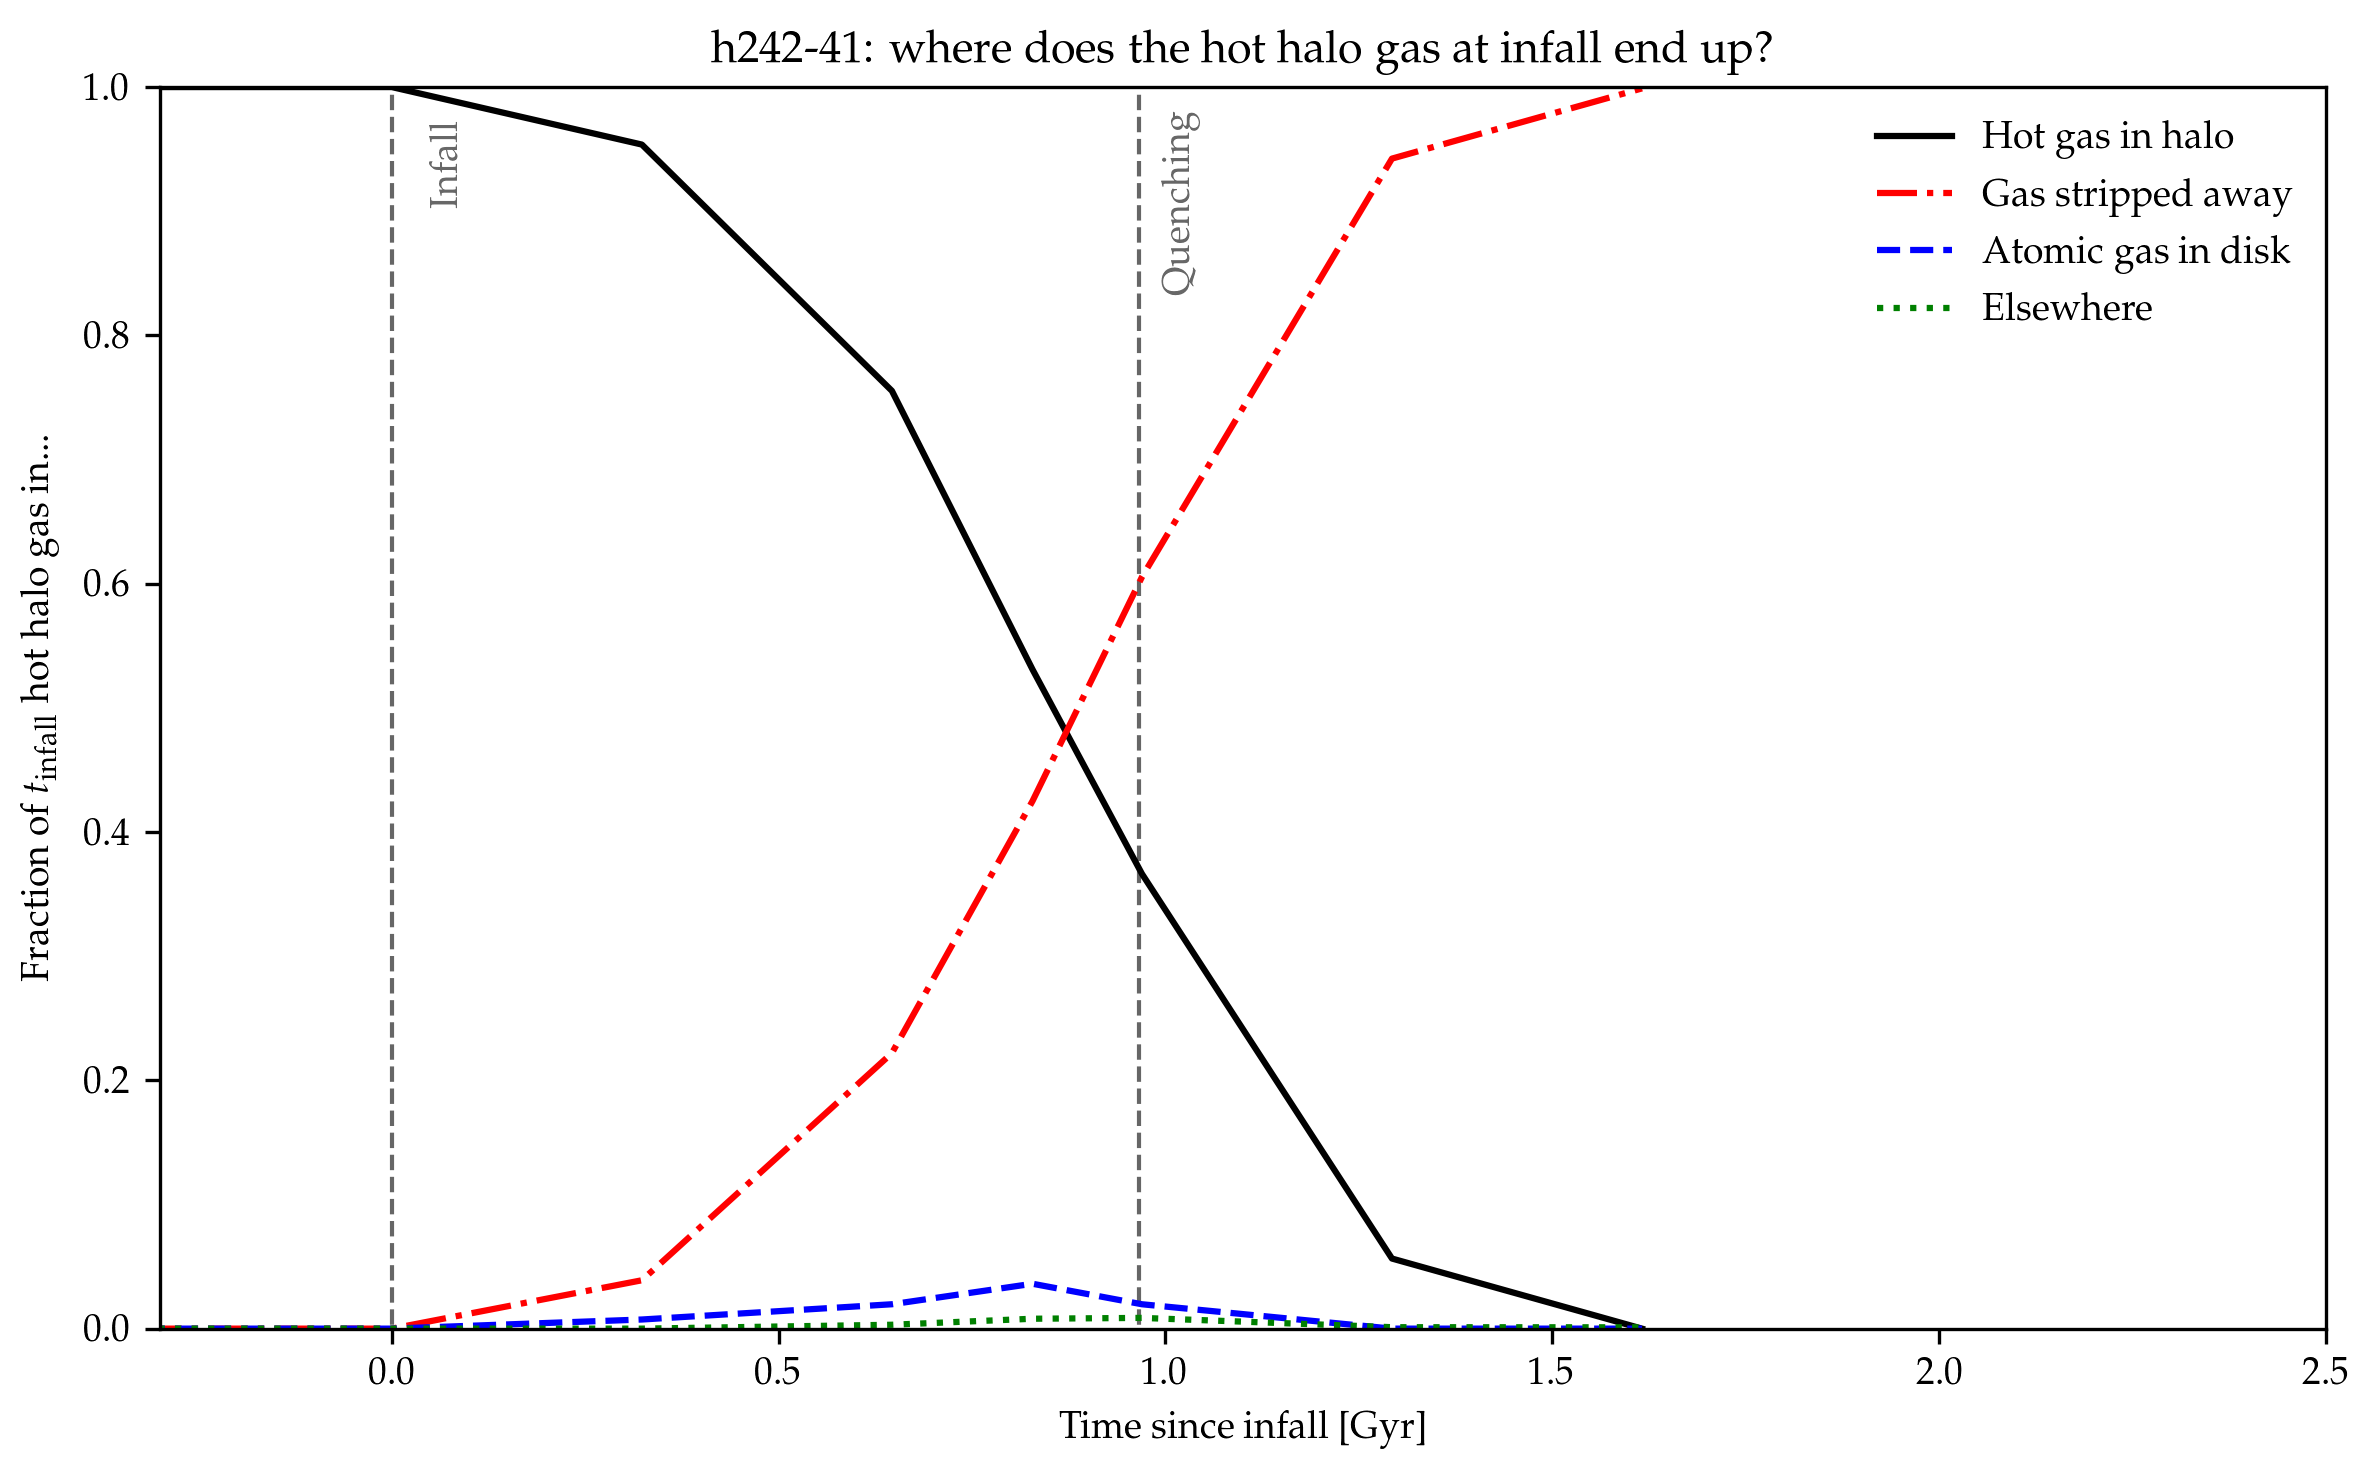

In [244]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=300)

frac_hot = np.array(fracs_hot)
frac_disk = np.array(fracs_disk)
frac_stripped = np.array(fracs_stripped)
frac_cool_halo = np.array(fracs_cool_halo)
frac_dense_halo = np.array(fracs_dense_halo)
frac_cooldense_halo = np.array(fracs_cooldense_halo)

t = np.array(ts) - (age-tinfall)
timescale = tinfall - tquench

ax.plot(t, frac_hot, 'k-', label='Hot gas in halo')

ax.plot(t, frac_stripped, 'r-.', label='Gas stripped away')

ax.plot(t, frac_disk, 'b--', label='Atomic gas in disk')
ax.plot(t, 1-frac_hot-frac_stripped-frac_disk, 'g:', label='Elsewhere')

ax.set_ylim(0, 1)
ax.set_xlim(-0.3,2.5)
ax.legend(frameon=False,ncol=1)

ax.plot([0,0],[-0.05,1.05], 'k--', alpha=0.6, zorder=0,linewidth=1)
ax.annotate('Infall',(0.05,0.91),alpha=0.6, rotation='vertical')
ax.plot([timescale,timescale],[-0.05,1.05],'k--', alpha=0.6, zorder=0,linewidth=1)
ax.annotate(r'Quenching',(timescale+0.03,0.84),alpha=0.6, rotation='vertical')

ax.set_xlabel('Time since infall [Gyr]')
ax.set_ylabel('Fraction of $t_{\mathrm{infall}}$ hot halo gas in...')
ax.set_title('h242-41: where does the hot halo gas at infall end up?')

plt.tight_layout()
# plt.savefig('h242_80_hot_gas_fractions.png',dpi=300)
plt.show()

In [260]:
def read_timescales():
    '''Function to read in the resulting data file which contains quenching and infall times'''
    data = []
    with open('/home/akinshol/Data/Timescales/QuenchingTimescales_sSFR_F19.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data = pd.DataFrame(data)
    return data


data = read_timescales()
data = data[(data.quenched==True)]
data['timescale'] = data.tinfall - data.tquench
data = data[data.timescale > 0]

data = data[(data.haloid == 55)|(data.haloid==22)|(data.haloid==41)]

data

,M_star,haloid,n_star,quenched,sim,tinfall,tinfall_lower,tinfall_upper,tquench,tquench_lower,tquench_upper,timescale
57,1.833826e+06,41,369,True,h242,2.478137,2.801372,2.478137,1.512063,1.512063,1.512063,0.966074
73,7.714878e+07,22,15673,True,h229,9.589313,9.589313,6.033725,5.183798,5.183798,2.549277,4.405516
80,6.790767e+06,55,1379,True,h229,5.710490,5.710490,5.387255,4.129031,4.129031,4.129031,1.581459


0.7116148154642445


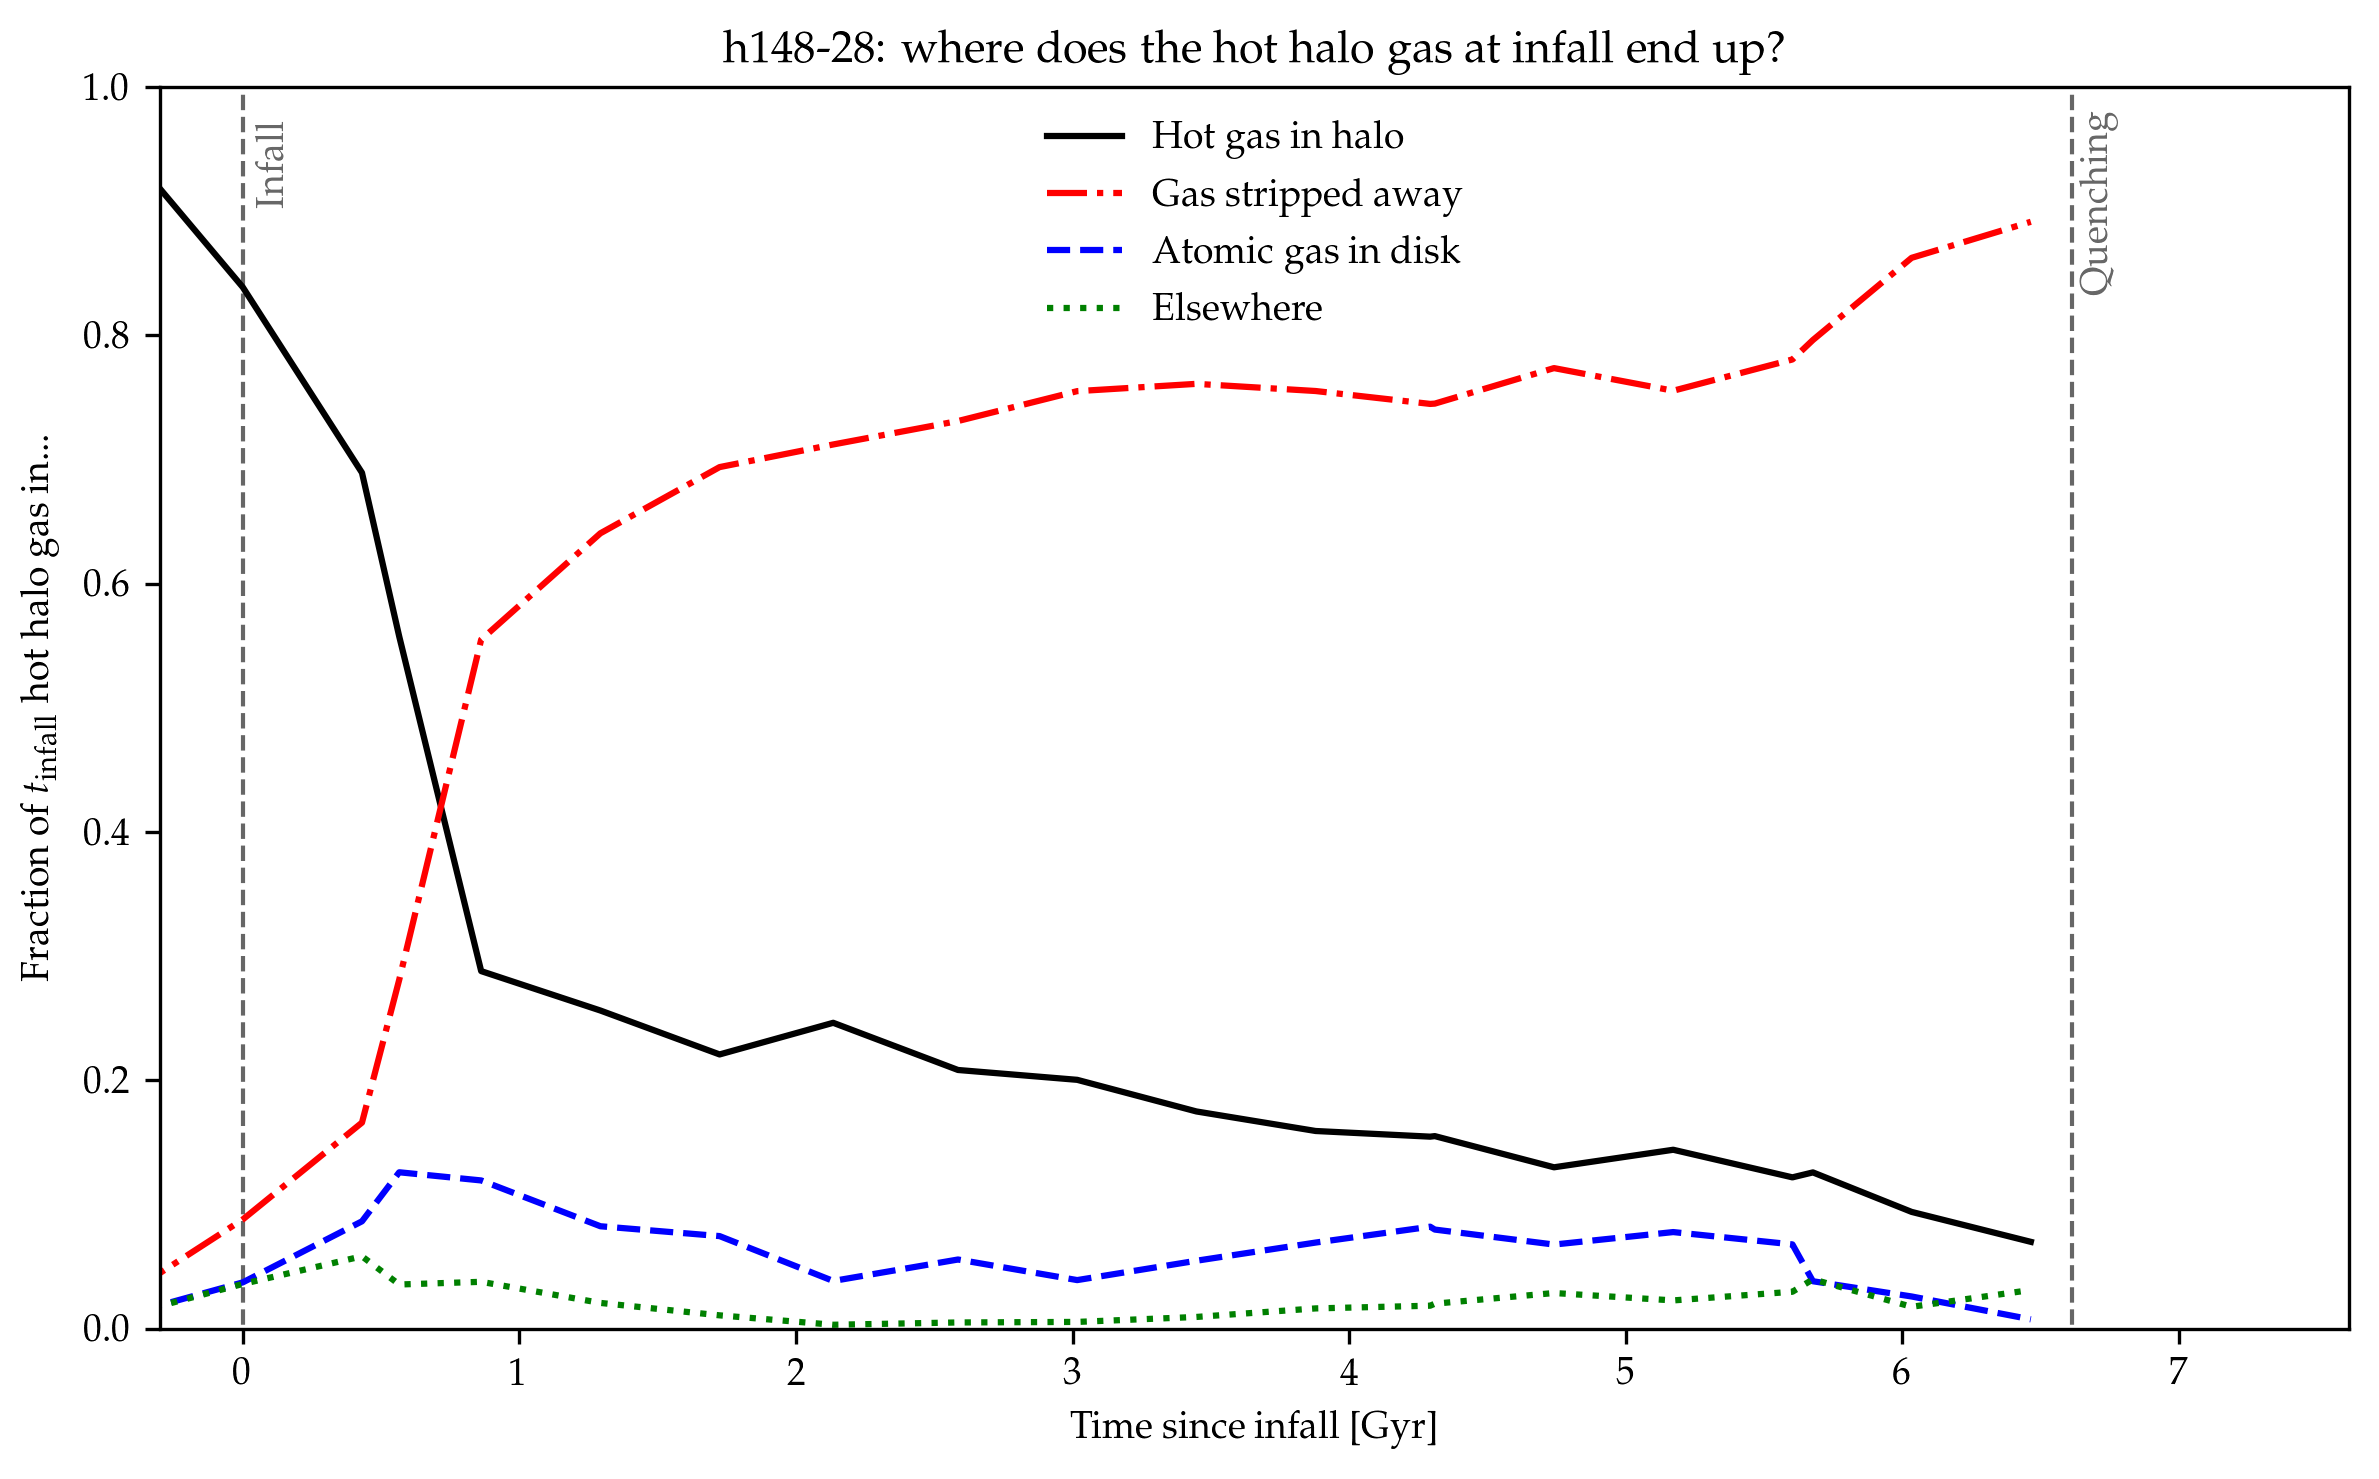

In [254]:
data = read_tracking_data()
data = data[(data.sim=='h148') & (data.haloid==28)]

timescale = np.mean(data.tinfall - data.tquench)
tinfall = np.mean(data.tinfall)
tquench = np.mean(data.tquench)
print(tquench)

t = data.t - (age-tinfall)

fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=300)

ax.plot(t, data.frac_hot, 'k-', label='Hot gas in halo')

ax.plot(t, data.frac_stripped, 'r-.', label='Gas stripped away')

ax.plot(t, data.frac_disk, 'b--', label='Atomic gas in disk')
ax.plot(t, 1-data.frac_hot-data.frac_stripped-data.frac_disk, 'g:', label='Elsewhere')

ax.set_ylim(0, 1)
ax.set_xlim(-0.3,timescale+1)
ax.legend(frameon=False,ncol=1)

ax.plot([0,0],[-0.05,1.05], 'k--', alpha=0.6, zorder=0,linewidth=1)
ax.annotate('Infall',(0.05,0.91),alpha=0.6, rotation='vertical')
ax.plot([timescale,timescale],[-0.05,1.05],'k--', alpha=0.6, zorder=0,linewidth=1)
ax.annotate(r'Quenching',(timescale+0.03,0.84),alpha=0.6, rotation='vertical')

ax.set_xlabel('Time since infall [Gyr]')
ax.set_ylabel('Fraction of $t_{\mathrm{infall}}$ hot halo gas in...')
ax.set_title('h148-28: where does the hot halo gas at infall end up?')

plt.tight_layout()
# plt.savefig('h242_80_hot_gas_fractions.png',dpi=300)
plt.show()

# Debugging: How to track star formation? 

In [5]:
snapnums = ['004096', '004032', '003936', '003840', '003744', '003648', '003606', '003552', '003456', '003360', '003264', '003195', '003168', '003072','002976', '002880', '002784', '002688', '002592', '002554', '002496', '002400', '002304','002208', '002112', '002088', '002016', '001920', '001824','001740','001728','001632', '001536', '001475', '001440', '001344', '001269', '001248','001152', '001106', '001056', '000974', '000960','000864', '000776', '000768', '000672', '000637', '000576', '000480', '000456', '000384', '000347', '000288', '000275', '000225', '000192', '000188', '000139', '000107', '000096', '000071']

haloids = {
    1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 4, 4, 4, 2],
    10: [10, 10, 9, 7, 7, 8, 7, 7, 7, 4, 5, 5, 5, 6, 6, 4, 3, 3, 3, 3, 3, 4, 5, 5, 6, 6, 4, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 6, 9, 9, 9, 10, 10, 9, 13, 14, 16, 18, 18, 18, 20],
    12: [12, 12, 12, 9, 10, 11, 10, 10, 10, 9, 10, 6, 6, 5, 4, 3, 4, 4, 4, 4, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 4, 4, 4, 4, 4, 5, 6, 6, 7, 8, 8, 8, 8, 10, 11, 10, 7, 6, 11, 11, 7, 11, 11, 9, 5, 6, 9],
    24: [24, 24, 25, 26, 25, 25, 25, 24, 24, 23, 24, 25, 24, 22, 22, 22, 21, 20, 19, 19, 19, 19, 19, 20, 19, 19, 17, 20, 21, 21, 20, 21, 17, 16, 17, 15, 15, 16, 15, 18, 17, 17, 17, 20, 21, 21, 20, 21, 24, 26, 28, 25, 24, 27, 29, 23, 20, 19, 14, 12, 16, 17],
    30: [30, 29, 29, 31, 29, 28, 29, 29, 30, 32, 30, 29, 28, 26, 25, 24, 22, 22, 20, 20, 20, 21, 21, 22, 21, 21, 18, 19, 18, 17, 16, 17, 15, 13, 14, 12, 13, 14, 13, 13, 13, 14, 14, 13, 15, 15, 14, 15, 16, 16, 17, 18, 16, 14, 12, 8, 9, 9, 8, 6, 5, 4],
    34: [34, 33, 34, 36, 35, 35, 34, 34, 35, 36, 33, 33, 33, 33, 33, 33, 33, 32, 32, 32, 32, 31, 31, 30, 30, 31, 28],
    40: [40, 40, 41, 44, 41, 41, 42, 41, 42, 42, 40, 39, 40, 39, 38, 38, 38, 38, 38, 38, 39, 38, 37, 38, 38, 38, 37, 36, 37, 35, 34, 34, 34, 32, 33, 34, 32, 34, 35, 38, 40, 38, 38, 42, 38, 38, 39, 40, 45, 50, 49, 49, 52, 57, 55, 50, 40, 41, 31, 25, 26],
    41: [41, 41, 42, 43, 44, 29, 26, 23, 20, 19, 19, 19, 19, 18, 18, 18, 19, 18, 18, 18, 18, 20, 20, 21, 22, 22, 21, 23, 28, 28, 28, 27, 29, 27, 28, 29, 27, 29, 32, 34, 35, 29, 29, 28, 26, 26, 34, 43, 121, 121, 115, 101, 103, 87, 82, 77, 122, 156, 122],
    44: [44, 44, 45, 48, 46, 45, 47, 46, 48, 50, 48, 50, 53, 51, 51, 52, 50, 52, 52, 53, 51, 51, 49, 50, 49, 50, 49, 50, 51, 48, 48, 45, 43, 39, 41, 41, 37, 39, 41, 46, 46, 46, 44, 46, 39, 39, 41, 41, 47, 53, 50, 46, 47, 50, 52, 53, 41, 40, 34, 30, 28, 25],
    48: [48, 50, 48, 51, 51, 50, 52, 51, 54, 54, 52, 53, 57, 55, 53, 53, 53, 54, 54, 54, 54, 53, 51, 49, 48, 48, 47, 51, 55, 54, 53, 57, 57, 57, 59, 60, 58, 61, 68, 68, 67, 67, 66, 69, 66, 66, 56, 57, 66, 67, 65, 59, 64, 71, 75, 85, 95, 94, 86, 77],
    49: [49, 49, 47, 50, 50, 49, 50, 50, 53, 55, 53, 55, 69, 56, 55, 55, 56, 55, 55, 57, 56, 58, 54, 57, 57, 57, 57, 60, 64, 65, 65, 69, 72, 73, 75, 79, 78, 83, 86, 86, 85, 81, 81, 83, 79, 79, 85, 94, 97, 100, 100, 103, 95, 92, 87, 91, 83, 84, 150],
    71: [71, 70, 72, 75, 75, 75, 75, 73, 72, 75, 71, 72, 72, 68, 66, 66, 67, 66, 66, 58, 57, 55, 53, 53, 50, 49, 48, 49, 53, 52, 51, 48, 48, 47, 50, 48, 42, 44, 46, 49, 48, 51, 53, 56, 50, 50, 48, 48, 56, 64, 62, 63, 65, 63, 58, 58, 55, 56, 47, 65],
    78: [78, 76, 76, 78, 76, 71, 70, 68, 64, 65, 63, 66, 65, 64, 62, 61, 62, 62, 60, 61, 59, 59, 60, 59, 59, 58, 56, 57, 60, 63, 62, 64, 62, 61, 62, 62, 60, 62, 67, 69, 68, 63, 63, 60, 45, 44, 47, 47, 54, 57, 51, 52, 62, 82, 77],
    80: [80, 268, 64, 39, 33, 31, 31, 30, 29, 29, 27, 26, 25, 25, 24, 19, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 14, 15, 14, 14, 13, 12, 12, 11, 11, 12, 13, 12, 14, 15, 15, 15, 15, 17, 17, 16, 17, 18, 21, 22, 29, 55, 53, 50, 47, 48, 48, 100],
    86: [86, 82, 83, 84, 82, 79, 80, 80, 76, 67, 51, 48, 47, 46, 47, 46, 46, 47, 45, 46, 45, 43, 42, 40, 39, 39, 38, 37, 39, 36, 35, 35, 35, 33, 34, 38, 35, 37, 36, 39, 42, 37, 35, 40, 41, 41, 51, 54, 58, 58, 56, 55, 57, 74, 73, 76, 88, 87, 112],
    165: [165, 153, 146, 140, 132, 125, 126, 129, 128, 134, 132, 131, 134, 128, 129, 127, 128, 127, 132, 132, 135, 136, 132, 125, 122, 116, 111, 113, 194, 133, 121, 87, 87, 92, 94, 97, 99, 102, 111, 108, 107, 102, 101, 102, 98, 101, 101, 105, 103, 95, 91, 90, 90, 91, 86, 68, 65, 64, 62],
    223: [223, 214, 228, 69, 52, 48, 48, 47, 49, 52, 50, 51, 54, 52, 52, 51, 51, 53, 53, 52, 50, 50, 48, 48, 51, 51, 50, 52, 54, 53, 52, 49, 50, 49, 52, 52, 47, 50, 49, 50, 50, 49, 49, 51, 44, 45, 49, 50, 55, 56, 54, 95, 134, 140, 135, 134, 157, 184, 146],
    439: [439, 441, 439, 442, 439, 432, 431, 430, 416, 401, 379, 367, 366, 341, 318, 283, 223, 176, 174, 170, 174, 173, 176, 178, 174, 173, 174, 176, 176, 176, 175, 168, 158, 141, 136, 122, 89, 78, 65, 63, 60, 53, 52, 43, 31, 31, 22, 22, 23, 27, 27, 26, 26, 30, 30, 31, 34, 36, 74],
    480: [480, 481, 466, 463, 462, 461, 459, 456, 460, 470, 467, 469, 472, 468, 472, 471, 460, 450, 437, 432, 425, 419, 415, 408, 409, 405, 408, 405, 405, 413, 411, 410, 404, 399, 393, 393, 368, 368, 356, 351, 342, 321, 320, 294, 224, 215, 118, 104, 89, 62, 57, 51, 54, 55, 54, 52, 49, 47, 37, 38, 42]
}

rvirs = {
    10: [105.92, 104.34, 102.0, 99.69, 97.4, 95.14, 94.15, 92.89, 90.67, 88.47, 86.29, 84.74, 84.13, 81.98, 79.85, 77.73, 75.62, 73.53, 71.44, 70.61, 69.36, 67.28, 65.21, 63.13, 61.06, 60.54, 58.98, 56.9, 54.81, 52.97, 52.7, 50.58, 48.45, 47.08, 46.3, 44.06, 42.13, 41.56, 38.83, 37.4, 35.91, 33.52, 33.11, 30.53, 28.43, 28.19, 24.91, 23.19, 18.23, 14.15, 13.46, 11.47, 10.1, 7.62, 7.25, 5.41, 4.35, 4.19, 2.65, 1.89, 1.58, 0.81],
    12: [88.48, 87.16, 85.21, 83.27, 81.36, 79.47, 78.65, 77.6, 75.74, 73.9, 72.08, 70.78, 70.28, 68.48, 66.7, 64.93, 63.17, 61.42, 59.67, 59.05, 58.15, 56.77, 55.59, 62.19, 60.15, 59.64, 58.1, 56.05, 53.99, 52.18, 51.92, 49.83, 39.06, 33.66, 34.57, 45.55, 43.99, 43.13, 39.62, 37.89, 34.53, 27.88, 27.33, 24.31, 22.18, 21.98, 19.33, 18.4, 16.21, 13.71, 13.23, 11.97, 10.82, 7.5, 7.12, 5.56, 4.48, 4.35, 3.2, 2.49, 2.13, 1.21],
    24: [49.2, 48.46, 47.38, 46.3, 45.24, 44.19, 43.73, 43.15, 42.12, 41.09, 40.08, 39.36, 39.08, 38.08, 37.09, 36.1, 35.13, 34.15, 33.18, 32.8, 32.21, 31.25, 30.29, 29.32, 31.43, 31.8, 31.02, 29.89, 28.68, 27.66, 27.51, 26.4, 25.37, 24.78, 24.41, 23.28, 22.28, 21.98, 20.39, 19.15, 18.25, 16.54, 16.31, 14.66, 13.4, 13.28, 11.77, 11.19, 10.19, 8.71, 8.33, 7.1, 6.53, 5.51, 5.26, 4.38, 3.82, 3.74, 2.88, 2.05, 1.73, 0.97],
    30: [61.77, 60.85, 59.48, 58.14, 56.8, 55.48, 54.91, 54.17, 52.88, 51.6, 50.32, 49.42, 49.06, 47.81, 46.57, 45.33, 44.1, 42.88, 41.66, 41.18, 40.45, 39.24, 38.03, 36.82, 35.61, 35.31, 34.4, 33.18, 31.96, 30.89, 30.73, 29.5, 28.25, 27.45, 26.99, 25.93, 24.91, 24.62, 23.21, 22.59, 21.74, 20.29, 20.07, 18.42, 17.02, 16.9, 15.66, 15.13, 13.66, 11.27, 10.86, 9.41, 8.44, 7.11, 6.78, 5.54, 4.71, 4.59, 3.26, 2.42, 2.21, 1.54],
    34: [44.33, 43.67, 42.69, 41.73, 40.79, 39.81, 39.4, 38.86, 37.92, 36.95, 36.03, 35.34, 35.09, 34.17, 33.23, 32.33, 31.44, 30.56, 29.65, 29.31, 28.77, 27.92, 27.05, 26.23, 25.45, 25.26, 24.75],
    40: [41.29, 40.67, 39.76, 38.86, 37.97, 37.08, 36.7, 36.21, 35.34, 34.48, 33.64, 33.03, 32.79, 31.96, 31.14, 30.31, 29.49, 28.63, 27.8, 27.46, 26.94, 26.06, 25.17, 24.34, 23.46, 23.24, 22.6, 21.71, 20.81, 19.98, 19.85, 18.94, 18.05, 17.5, 17.19, 16.3, 15.55, 15.32, 14.25, 13.79, 13.33, 12.48, 12.32, 11.15, 10.17, 10.08, 9.0, 8.58, 7.91, 6.74, 6.38, 5.26, 4.8, 3.97, 3.8, 3.26, 2.85, 2.8, 2.24, 1.48, 1.23],
    41: [55.33, 54.51, 53.29, 52.08, 50.88, 49.7, 49.19, 48.53, 47.37, 46.22, 45.08, 44.27, 43.94, 42.73, 41.55, 40.34, 39.34, 38.13, 36.91, 36.5, 35.8, 34.67, 33.32, 31.91, 30.06, 29.59, 28.28, 25.97, 23.05, 21.99, 21.84, 20.72, 19.64, 18.94, 18.51, 17.37, 16.51, 16.26, 15.14, 14.6, 14.06, 13.59, 13.51, 12.81, 11.85, 11.72, 9.82, 8.24, 5.54, 4.48, 4.31, 3.78, 3.45, 3.13, 3.0, 2.46, 1.75, 1.53, 1.14],
    44: [38.42, 37.82, 36.96, 36.11, 35.24, 34.38, 34.01, 33.53, 32.7, 31.87, 31.04, 30.42, 30.19, 29.36, 28.57, 27.74, 26.92, 26.11, 25.31, 24.99, 24.5, 23.7, 22.89, 22.09, 21.3, 21.09, 20.5, 19.75, 19.02, 18.42, 18.35, 17.73, 17.09, 16.65, 16.37, 15.49, 14.8, 14.59, 13.66, 13.22, 12.75, 11.93, 11.79, 10.88, 9.96, 9.87, 8.78, 8.4, 7.75, 6.61, 6.32, 5.41, 4.94, 4.18, 3.95, 3.11, 2.85, 2.81, 2.07, 1.38, 1.18, 0.77],
    48: [37.88, 37.29, 36.41, 35.51, 34.64, 33.78, 33.41, 32.92, 32.07, 31.23, 30.39, 29.81, 29.57, 28.76, 27.96, 27.18, 26.42, 25.67, 24.96, 24.66, 24.23, 23.53, 22.82, 22.11, 21.4, 21.21, 20.58, 19.71, 18.82, 18.04, 17.92, 16.95, 16.06, 15.52, 15.2, 14.27, 13.53, 13.33, 12.4, 12.01, 11.54, 10.75, 10.61, 9.62, 8.91, 8.84, 7.89, 7.52, 6.78, 5.7, 5.46, 4.84, 4.4, 3.45, 3.15, 2.35, 1.89, 1.87, 1.27, 0.89],
    49: [37.85, 37.29, 36.41, 35.55, 34.72, 33.88, 33.5, 33.0, 32.12, 31.23, 30.34, 29.56, 18.01, 28.63, 27.79, 26.88, 26.03, 25.28, 24.47, 24.18, 23.73, 22.94, 22.14, 21.34, 20.52, 20.31, 19.66, 18.71, 17.71, 16.89, 16.78, 15.91, 15.04, 14.49, 14.19, 13.29, 12.63, 12.42, 11.56, 11.13, 10.7, 9.93, 9.82, 9.01, 8.2, 8.11, 7.06, 6.59, 5.91, 4.78, 4.51, 3.77, 3.62, 3.1, 2.96, 2.27, 2.0, 1.94, 1.05],
    71: [33.16, 32.66, 31.94, 31.25, 30.54, 29.83, 29.55, 29.18, 28.52, 27.93, 27.39, 27.0, 26.86, 28.14, 27.41, 26.68, 25.96, 25.24, 24.52, 24.24, 23.81, 23.1, 22.38, 20.89, 21.29, 21.11, 20.54, 19.75, 18.96, 18.23, 18.13, 17.34, 16.58, 16.08, 15.81, 15.03, 14.44, 14.25, 13.42, 13.04, 12.6, 11.64, 11.5, 10.32, 9.22, 9.15, 8.19, 7.83, 7.1, 5.73, 5.51, 4.77, 4.32, 3.74, 3.6, 2.96, 2.47, 2.38, 1.68, 0.96],
    78: [35.38, 34.86, 34.08, 33.3, 32.54, 31.78, 31.45, 31.03, 30.29, 29.56, 28.83, 28.31, 28.11, 27.39, 26.68, 25.98, 25.27, 24.57, 23.88, 23.6, 23.2, 22.5, 21.82, 21.12, 20.42, 20.23, 19.67, 18.88, 18.09, 17.39, 17.29, 16.48, 15.62, 15.12, 14.82, 14.06, 13.42, 13.24, 12.38, 11.92, 11.46, 10.79, 10.67, 10.07, 9.4, 9.32, 8.26, 7.8, 7.12, 6.35, 6.26, 5.22, 4.48, 3.22, 3.11],
    80: [68.36, 67.35, 65.84, 64.34, 62.87, 61.4, 60.77, 59.96, 58.52, 57.11, 55.7, 54.69, 54.3, 52.92, 51.54, 50.17, 48.81, 47.46, 46.11, 45.58, 44.77, 43.4, 42.12, 40.55, 38.58, 38.19, 37.01, 35.42, 33.83, 32.5, 32.31, 30.91, 29.55, 28.81, 28.37, 27.11, 25.87, 25.51, 23.73, 22.22, 21.21, 19.34, 18.93, 16.65, 14.74, 14.67, 13.51, 13.09, 12.06, 9.95, 9.36, 6.66, 4.68, 4.08, 3.98, 3.38, 2.73, 2.62, 1.19],
    86: [38.75, 38.17, 37.32, 36.47, 35.63, 34.8, 34.44, 33.98, 33.17, 32.37, 31.57, 31.0, 30.78, 29.99, 29.21, 28.44, 27.62, 26.8, 26.06, 24.52, 25.32, 24.68, 24.1, 23.62, 23.19, 23.06, 22.6, 21.76, 20.78, 19.94, 19.82, 18.85, 17.94, 17.29, 16.87, 15.83, 15.07, 14.87, 14.11, 13.73, 13.27, 12.62, 12.5, 11.29, 9.92, 9.78, 8.02, 7.55, 6.97, 6.27, 6.01, 5.13, 4.6, 3.34, 3.2, 2.46, 1.93, 1.89, 1.16],
    165: [26.0, 25.61, 25.04, 24.47, 23.91, 23.35, 23.11, 22.8, 22.26, 21.72, 21.1, 20.69, 20.52, 19.93, 19.36, 18.76, 18.19, 17.6, 17.03, 16.79, 16.46, 15.92, 15.45, 15.14, 15.12, 15.16, 15.28, 12.2, 3.89, 6.46, 7.69, 14.29, 13.61, 13.17, 12.91, 12.13, 11.56, 11.39, 10.64, 10.29, 9.88, 9.21, 9.08, 8.28, 7.58, 7.51, 6.71, 6.36, 5.76, 4.84, 4.64, 4.02, 3.69, 3.1, 2.98, 2.68, 2.3, 2.24, 1.44],
    223: [37.97, 37.4, 36.56, 35.73, 34.91, 34.1, 33.75, 33.3, 32.5, 31.71, 30.9, 30.33, 30.11, 29.35, 28.56, 27.77, 26.92, 26.12, 25.32, 25.0, 24.51, 23.7, 22.91, 22.1, 21.29, 21.09, 20.46, 19.65, 18.85, 18.19, 18.09, 17.33, 16.51, 16.01, 15.68, 14.87, 14.16, 13.97, 13.28, 12.96, 12.44, 11.73, 11.61, 10.48, 9.42, 9.31, 8.07, 7.65, 7.05, 6.37, 6.08, 3.92, 3.09, 2.58, 2.49, 1.98, 1.53, 1.41, 1.06],
    439: [21.41, 21.09, 20.62, 20.15, 19.69, 19.23, 19.03, 18.78, 18.33, 17.88, 17.44, 17.13, 17.01, 16.57, 16.14, 15.71, 15.29, 14.86, 14.44, 14.27, 14.02, 13.6, 13.17, 12.74, 12.33, 12.2, 11.89, 11.43, 10.99, 10.63, 10.59, 10.23, 10.1, 10.22, 10.34, 13.47, 12.94, 12.8, 12.11, 11.9, 11.63, 11.23, 11.19, 10.78, 10.69, 10.7, 10.99, 9.89, 10.21, 8.62, 8.38, 6.92, 6.32, 5.36, 5.07, 3.96, 2.99, 2.84, 1.37],
    480: [16.63, 16.38, 16.02, 15.65, 15.29, 14.94, 14.78, 14.59, 14.24, 13.89, 13.55, 13.3, 13.21, 12.87, 12.54, 12.2, 11.87, 11.54, 11.22, 11.09, 10.89, 10.56, 10.24, 9.91, 9.59, 9.47, 9.19, 8.9, 8.59, 8.28, 8.26, 7.9, 7.61, 7.7, 7.57, 7.21, 6.93, 6.85, 6.48, 6.33, 6.19, 5.87, 5.85, 5.53, 5.49, 5.48, 5.5, 6.25, 6.0, 5.71, 5.71, 5.16, 4.72, 4.05, 3.9, 3.13, 2.69, 2.64, 1.92, 1.27, 1.01]
}

In [21]:
age = 13.800797497330507


s = 'h242'
z0haloid = 80

i1 = 20 # starting snapshot index

f_base = f'/home/christenc/Data/Sims/{s}.cosmo50PLK.3072g/{s}.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/{s}.cosmo50PLK.3072gst5HbwK1BH.'

f1 = f_base + snapnums[i1]
s1 = pynbody.load(f1)
s1.physical_units()
h1 = s1.halos()
f2 = f_base + snapnums[i1-1]
s2 = pynbody.load(f2)
s2.physical_units()
h2 = s2.halos()

gas_cool_filt = pynbody.filt.LowPass('temp', 1e4) # select all gas particles with T > 1e4 K
gas_highdens_filt = pynbody.filt.HighPass('rho',2453000) # select all gas particles with rho < 0.1 amu/cc (converted into Msol/kpc**3)
gas_radial_filt = pynbody.filt.LowPass('r', 0.2*rvirs[z0haloid][i1])
gas_filt = gas_cool_filt & gas_highdens_filt & gas_radial_filt

In [7]:
b = pynbody.bridge.OrderBridge(s1, s2, allow_family_change=True)

In [8]:
halo1 = h1[1].g

In [9]:
len(halo1.g)

3439465

In [10]:
halo2 = b(halo1)

In [11]:
len(halo2.s), len(halo2.g)

(0, 3391298)

so there's a significant loss in gas particles between these two snapshots, but no increase in star particles. Presumably, halo 1 is forming lots of stars, but the pynbody bridge function isn't able to track the gas particles that form stars. 

In [12]:
print(f"Lost {np.sum(halo1.g['mass'])-np.sum(halo2.g['mass']):.2e} Msol of gas mass")

Lost 1.31e+09 Msol of gas mass


In [23]:
sl = pynbody.tipsy.StarLog(f_base+'starlog', sort=False)

ValueError: string size must be a multiple of element size

In [16]:
tform = s2.s['tform'].in_units('Gyr') - s2.properties['time'].in_units('Gyr'); tform
deltat = s1.properties['time'].in_units('Gyr') - s2.properties['time'].in_units('Gyr')
print(deltat)

igasorder_s2 = s2.s['igasorder']
massform = s2.s['mass']
iorder_halo1 = halo1.g['iord']

mass_formed_stars = np.sum(massform[np.isin(igasorder_s2, iorder_halo1)])
print(f"Formed {mass_formed_stars:.2e} Msol of stars")

Formed 2.10e+10 Msol of stars


In [ ]:
massform = s2.s['massform']
igasorder = s2.s['igasorder']

mass_formed_stars = np.sum(massform[np.isin(igasorder_s2, iorder_halo1)])

In [57]:
a = np.array(igasorder_s2); a

array([8959539, 6303380, 7323705, ..., 1345525,  986317,  368749])

In [58]:
b = np.array(iorder_halo1); b

array([   64999,    66175,    66246, ..., 11018470, 11028720, 11029879])

In [59]:
len(np.intersect1d(a,b))

208780

In [60]:
len(np.unique(igasorder_s2)) - len(igasorder_s2)

-71381

In [61]:
len(np.unique(iorder_halo1)) - len(iorder_halo1)

0

In [63]:
halo.derivable_keys()

['HII',
 'HeIII',
 'ne',
 'hetot',
 'hydrogen',
 'feh',
 'oxh',
 'ofe',
 'mgfe',
 'nefe',
 'sife',
 'c_s',
 'c_s_turb',
 'mjeans',
 'mjeans_turb',
 'ljeans',
 'ljeans_turb',
 'smooth',
 'rho',
 'r',
 'rxy',
 'vr',
 'v2',
 'vt',
 'ke',
 'te',
 'j',
 'j2',
 'jz',
 'vrxy',
 'vcxy',
 'vphi',
 'vtheta',
 'v_mean',
 'v_disp',
 'age',
 'u_mag',
 'u_lum_den',
 'b_mag',
 'b_lum_den',
 'v_mag',
 'v_lum_den',
 'r_mag',
 'r_lum_den',
 'i_mag',
 'i_lum_den',
 'j_mag',
 'j_lum_den',
 'h_mag',
 'h_lum_den',
 'k_mag',
 'k_lum_den',
 'U_mag',
 'U_lum_den',
 'B_mag',
 'B_lum_den',
 'V_mag',
 'V_lum_den',
 'R_mag',
 'R_lum_den',
 'I_mag',
 'I_lum_den',
 'J_mag',
 'J_lum_den',
 'H_mag',
 'H_lum_den',
 'K_mag',
 'K_lum_den',
 'theta',
 'alt',
 'az',
 'cs',
 'mu',
 'p',
 'u',
 'temp',
 'zeldovich_offset',
 'aform',
 'tform']

In [133]:
pynbody.analysis.halo.center(halo)

In [134]:
filt = pynbody.filt.LowPass('r', 10)
halo_filt = halo[filt]
halo_filt

<SimSnap "/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h242.cosmo50PLK.3072gst5HbwK1BH.002496:halo_1:lowpass_r" len=12942461>

In [135]:
len(halo_filt.s), len(halo_filt.g)

(11030065, 378552)

In [136]:
filt1 = pynbody.filt.LowPass('r', 10)
filt2 = pynbody.filt.LowPass('r', 5)
filt = filt1 & filt2
halo_filt = halo[filt]
halo_filt

<SimSnap "/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h242.cosmo50PLK.3072gst5HbwK1BH.002496:halo_1:lowpass_r&lowpass_r" len=10360025>

In [137]:
len(halo_filt.s), len(halo_filt.g)

(9512969, 133770)

In [158]:
b = pynbody.bridge.OrderBridge(s1, s2)#, allow_family_change=True, monotonic=False)

In [155]:
halo_filt2 = b(halo_filt)

In [156]:
len(halo_filt2.s), len(halo_filt2.g)

(9512969, 118494)

In [152]:
?b

Signature:      b(s)
Type:           OrderBridge
String form:    <pynbody.bridge.OrderBridge object at 0x7f6b5b304438>
File:           ~/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/bridge/__init__.py
Docstring:     
An OrderBridge uses integer arrays in two simulations
(start,end) where particles i_start and i_end are
defined to be the same if and only if
start[order_array][i_start] == start[order_array][i_end].

If monotonic is True, order_array must be monotonically increasing
in both ends of the bridge (and this is not checked for you). If
monotonic is False, the bridging is slower but this is the
failsafe option.
Call docstring:
Given a subview of either the start or end point of the bridge,
generate the corresponding subview of the connected snapshot
